<a href="https://colab.research.google.com/github/nobu-n2002/CFD2023_image_processing/blob/main/ibm_image_processing_PythonSolverVer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Preprocessing for Immersed Boundary Method

In this notebook, general image processing techniques are employed on 2D images and subsequently applied to a numerical simulation program utilizing A new unified governing equation of flow incorporating immersed solid boundaries.

## Basic equation

Law of conservation of mass:
\begin{align}
\frac{\partial \rho \varepsilon}{\partial t}+\boldsymbol{\bigtriangledown} \cdot \rho \varepsilon \boldsymbol{u} = 0
\end{align}

Law of conservation of momentum:
\begin{align}
\frac{\partial \rho \varepsilon \boldsymbol{u}}{\partial t}+\bigtriangledown \cdot \rho \varepsilon \boldsymbol{u} \boldsymbol{u}
= -\varepsilon\bigtriangledown p + \bigtriangledown\cdot \varepsilon \boldsymbol{T} + \boldsymbol{f}\\
\boldsymbol{T} = \mu(\bigtriangledown\boldsymbol{u}+\bigtriangledown\boldsymbol{u}^t)+\lambda (\bigtriangledown\cdot\boldsymbol{u})\boldsymbol{I}
\end{align}

Defenition of porosity distribution:

\begin{align}
\displaystyle \varepsilon = \frac{1}{2} \tanh(x) + \frac{1}{2},  x = \frac{\xi}{\Delta}
\end{align}

where $\xi$ is a signed distance function.

# 1. Preparation before execution

## Connect to Google Drive
If you wish to execute while connecting to Google Drive, enable `connect: [check]`. Upon execution, access to Google Drive will be requested. Once approved, you will have access to your own drive.

In [ ]:
# @title Connect to Google Drive { run: "auto", vertical-output: true, display-mode: "form" }

from google.colab import drive

# Parameters
connect = False  # @param {type:"boolean"}

# Mount Google Drive if selected
if connect:
    drive.mount('/content/drive')
    print('Google Drive connected!')
else:
    print('Google Drive not connected.')


Google Drive not connected.


## Importing non-standard modules
Install non-standard modules on Google Colab. This won't affect your local environment. The execution may take around 1 minute.

In [1]:
#@title Importing non-standard modules into Colabo

%%capture

# update apt-get and upgrade pip (for installing modules)
!apt-get update
!apt-get upgrade pip

# pyheif : use to convert heic files to png
%pip install pyheif

# For using skfmm which is a tool to compute SDF (signed distance field)
%pip install scikit-fmm

%pip install vtk

# pyvista : use to visualise vtk files
!apt-get install xvfb libgl1-mesa-glx
%pip install pyvista

# 2. Image processing

The image file is converted to grayscale, and a blur is applied as a variant distance function to generate a porosity distribution.


## 2-1. File Input
Enable `use_upload: [check]` to choose a local file. Alternatively, manually input the file path for the uploaded file in `./content/` into `file_path:`.

Creating a tmp folder
sample (10) successfully read
Original resolution: (756, 756)
Save the figure in ./tmp/original.png


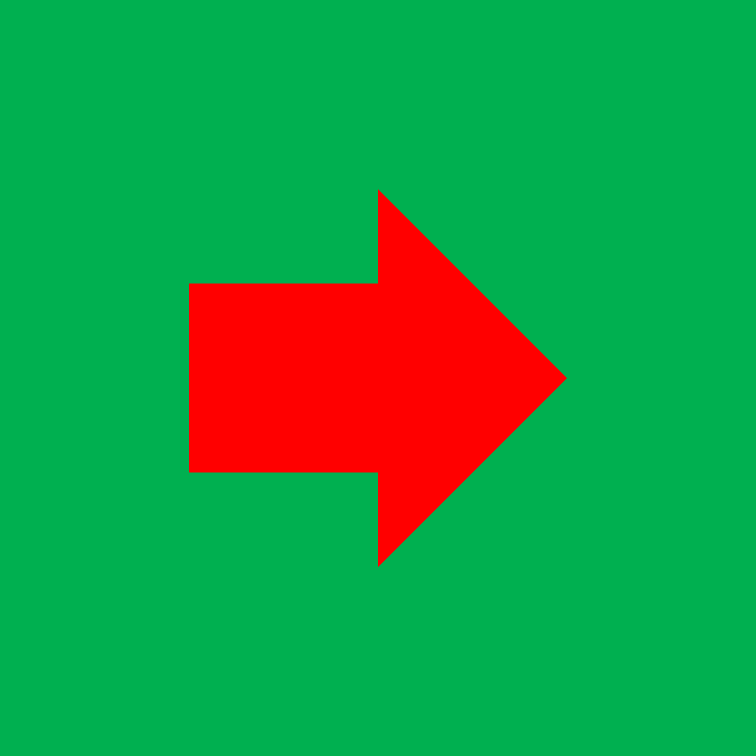

In [2]:
# @title File Input { vertical-output: true, display-mode: "form" }

import os
import sys
from IPython.display import display, Image
import cv2
import pyheif
from google.colab import files

# Function to convert HEIC to PNG
def heif_to_image(path):
    heif_file = pyheif.read(path)
    img = Image.frombytes(heif_file.mode,
                          heif_file.size,
                          heif_file.data,
                          "raw",
                          heif_file.mode,
                          heif_file.stride,)
    print('HEIC successfully converted into PNG')
    return img

# Parameters
use_upload = False  # @param {type:"boolean"}
file_path = "/content/sample (10).png"  # @param {type:"string"}
upload_button = None

# Check if 'tmp' folder exists, create if not
if not os.path.exists('tmp'):
    print('Creating a tmp folder')
    os.mkdir('tmp')

# Upload files if selected
if use_upload:
    upload_button = files.upload()

# Get the file path
if use_upload and len(upload_button) > 0:
    file_path_input = list(upload_button.keys())[0]
    file_path = file_path_input
else:
    file_path_input = file_path

# Check if the file exists
if os.path.exists(file_path_input):
    file_name, file_extension = os.path.splitext(os.path.basename(file_path_input))

    # Check if the file is in HEIC format and convert to PNG if needed
    if file_extension.lower() == '.heic':
        img = heif_to_image(file_path_input)
        img.save(f"./tmp/{file_name}.png", "PNG")
        file_path = f"./tmp/{file_name}.png"

    print(f'{file_name} successfully read')
    original_image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    height, width = original_image.shape[0:2]

    file_path_original = f"./tmp/original.png"
    cv2.imwrite(file_path_original, original_image)

    print('Original resolution:', original_image.shape[0:2])
    print('\033[32m' + f'Save the figure in {file_path_original}' + '\033[0m')
    display(Image(file_path, width=500))
else:
    sys.exit('No file input')


## 2-2. Cropping and Adding Margins

Add padding to the loaded file. The original resolution of the file can be found in the code block above [File Input] with `Original resolution: (WIDTH, HEIGHT)`, allowing you to verify it. Add a margin of `MARGIN` pixels to match that resolution. Choose `surroundings` for padding around the image, or `x_direction` for padding only in the horizontal direction. If the image is not a square, check ☑ 'square' to reshape it into a square.


Original resolution: (756, 756)
Processed resolution: (1556, 1556)
Save the figure in /content/tmp/cropped.png


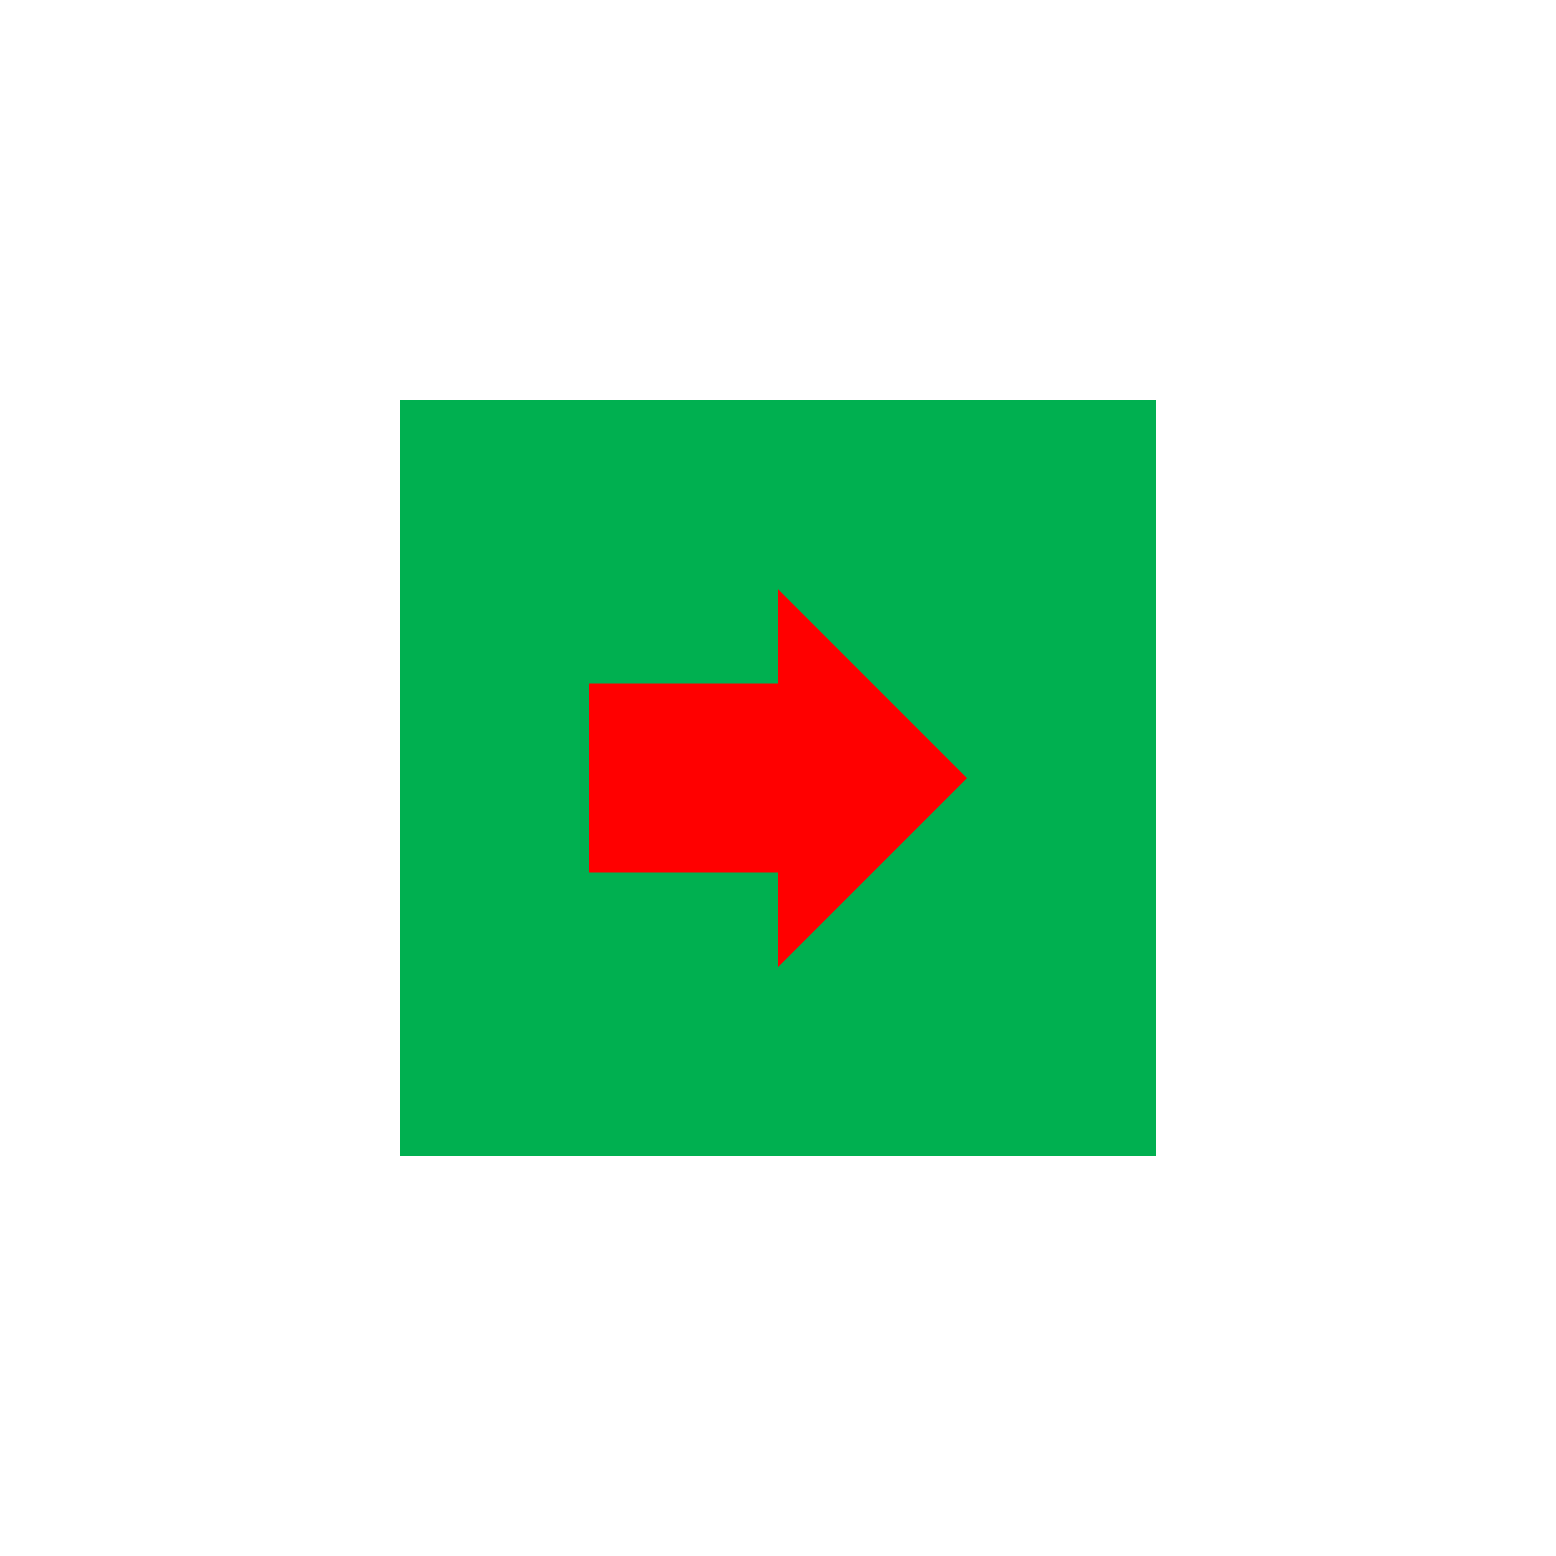

In [3]:
# @title Cropping and Adding Margins { run: "auto", vertical-output: true, display-mode: "form" }
# { run: "auto", vertical-output: true, display-mode: "form" }

# Import modules
import os
import cv2
from IPython.display import display, Image

# Create a tmp folder if it doesn't exist
TMP_FOLDER = 'tmp'
if not os.path.exists(TMP_FOLDER):
    print('Create a temp folder')
    os.mkdir(TMP_FOLDER)

# Parameters
MARGIN = 400 # @param {type:"slider", min:0, max:1000, step:10}

# Current working directory
CWD = os.getcwd()

file_path_original = f"./tmp/original.png"

# read an image resized
src = cv2.imread(file_path_original, cv2.IMREAD_UNCHANGED)
h_ori, w_ori = src.shape[0:2]
print('Original resolution:', src.shape[0:2])

# Set margin parameters
margin_type = "surroundings"  # @param ["x_direction", "surroundings"]
square = True # @param {type:"boolean"}
x, y = 0, 0
margin_factor_x, margin_factor_y = 0, 0

# Calculate margin for square
if square:
    tmp = h_ori - w_ori
    if tmp <= 0:
        x = int(abs(tmp) / 2)
    else:
        y = int(abs(tmp) / 2)

# Set margin factors based on type
if margin_type == "surroundings":
    margin_factor_x, margin_factor_y = 1, 1
elif margin_type == "x_direction":
    margin_factor_x, margin_factor_y = 0, 1

# Add margin to the image
img = cv2.copyMakeBorder(src, MARGIN * margin_factor_x + x, MARGIN * margin_factor_x + x,
                         MARGIN * margin_factor_y + y, MARGIN * margin_factor_y + y,
                         cv2.BORDER_CONSTANT, value=[255, 255, 255])

# Save the processed image
file_name_cropped = f"{CWD}/tmp/cropped.png"
cv2.imwrite(file_name_cropped, img)

# Display the processed image
print('Processed resolution:', img.shape[0:2])
print('\033[32m' + f'Save the figure in {file_name_cropped}' + '\033[0m')
display(Image(file_name_cropped, width=500))


##2-3. Grayscale

Grayscaling can be easily achieved by loading the previously resized image using OpenCV's `IMREAD_GRAYSCALE` function. Here, we explain the process that takes place within the image during the grayscaling process.

Each pixel in the image has a specific RGB (Red, Green, Blue) value, where each color has 256 steps ranging from 0 to 255 (i.e., $2^8$ or $16^2$). By performing the following operations on these RGB values, a grayscale image can be generated. This method follows the "Luminosity Method (ITU-R BT.601)."

$$ \rm{Gray} = Red \times 0.229 + Green \times 0.587 + Blue \times 0.114 $$

The following code block (the greyscale tester) conducts a test to convert an original BGR color (specified by user input) to grayscale by applying custom weights to each channel (B, G, R). Users can set these custom weights through sliders. The resulting grayscale intensity is calculated based on the specified weights, and the original and grayscale images are displayed side by side for visual comparison.

Original RGB: (0, 255, 0)       Gray: (254, 254, 254)


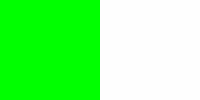

In [ ]:
# @title Grayscale Tester  { run: "auto", vertical-output: true, form-width: "600px" }
import cv2
import numpy as np
from IPython.display import Image

# Define custom weights for RGB to grayscale conversion
def custom_rgb_to_grayscale(image, weights=[0.229, 0.587, 0.114]):
    """
    Convert a 3-channel RGB image to grayscale using custom weights.

    Parameters:
    - image (numpy.ndarray): Input RGB image.
    - weights (list): Custom weights for each RGB channel. Default is [0.229, 0.587, 0.114].

    Returns:
    - numpy.ndarray: Grayscale image.
    """
    # Ensure the image has three color channels (RGB)
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Input image must be a 3-channel RGB image.")

    # Apply custom weights for RGB to grayscale conversion
    gray_image = np.dot(image[..., :3], weights)

    return gray_image

# @markdown ## Original color
# Parameters for original color
R = 28    # @param {type:"slider", min:0, max:255, step:1}
G = 255    # @param {type:"slider", min:0, max:255, step:1}
B = 28    # @param {type:"slider", min:0, max:255, step:1}

# @markdown $$ \rm{Gray} = Red \times w_1/w + Green\times w_2/w +Blue\times w_3/w $$
# @markdown $$ \rm{w} = w_1 + w_2 + w_3$$

# Custom weights for RGB to grayscale conversion
delta = 1e-6
w1 = 0.09    # @param {type:"slider", min:0, max:1, step:0.01}
w2 = 1    # @param {type:"slider", min:0, max:1, step:0.01}
w3 = 0.09    # @param {type:"slider", min:0, max:1, step:0.01}
w = w1 + w2 + w3 + delta

# BGR
custom_weights = [w3 / w, w2 / w, w1 / w]

Gray = int(R * w1 / w + G * w2 / w + B * w3 / w)
print(f'Original RGB: ({R}, {G}, {B})       Gray: ({Gray}, {Gray}, {Gray})')

# Generate 100×100(×[B, G, R]) image
omap = np.zeros((100, 100, 3), np.uint8)
omap[:, :, 0] = B
omap[:, :, 1] = G
omap[:, :, 2] = R

# Generate grayscale image
pmap = np.zeros((100, 100, 3), np.uint8)
pmap_tmp = custom_rgb_to_grayscale(omap, custom_weights)
pmap[:, :, 0] = Gray
pmap[:, :, 1] = Gray
pmap[:, :, 2] = Gray

# Concatenate the two images
dispmap = np.concatenate([omap, pmap], 1)

# Save the PNG file for display
cv2.imwrite('img.png', dispmap)
display(Image('img.png', width=600))

# Remove the PNG file
%rm img.png

###2-3-1. Threshold

When generating a grayscale image, set all values greater than the threshold to 255 (white). Adjust the grayscale weighting and threshold value to effectively lighten the background by enhancing its white tones.


Custom weights: [0.0, 1.0, 0.0]
Original color image


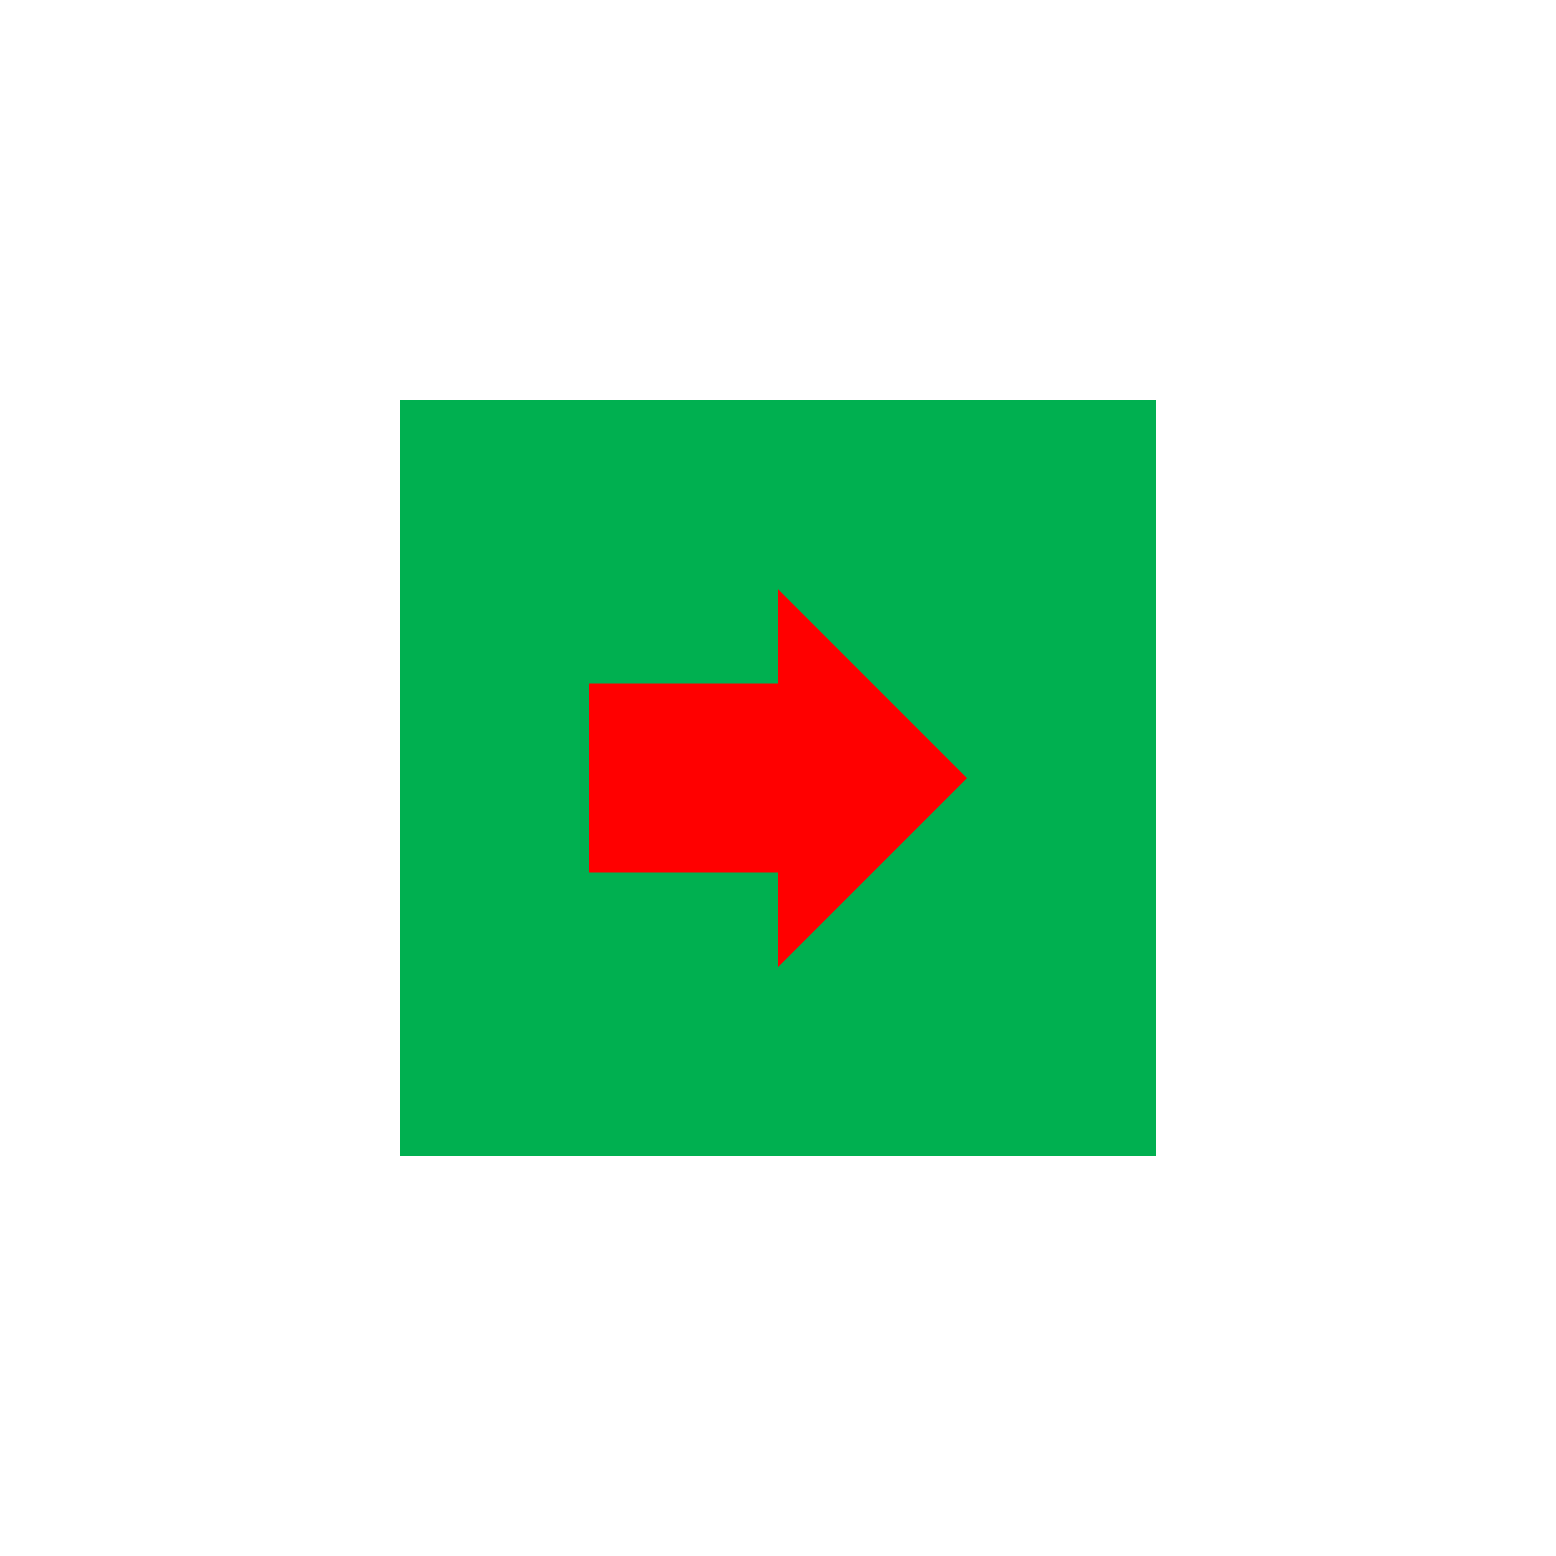

Grayscale and Threshold


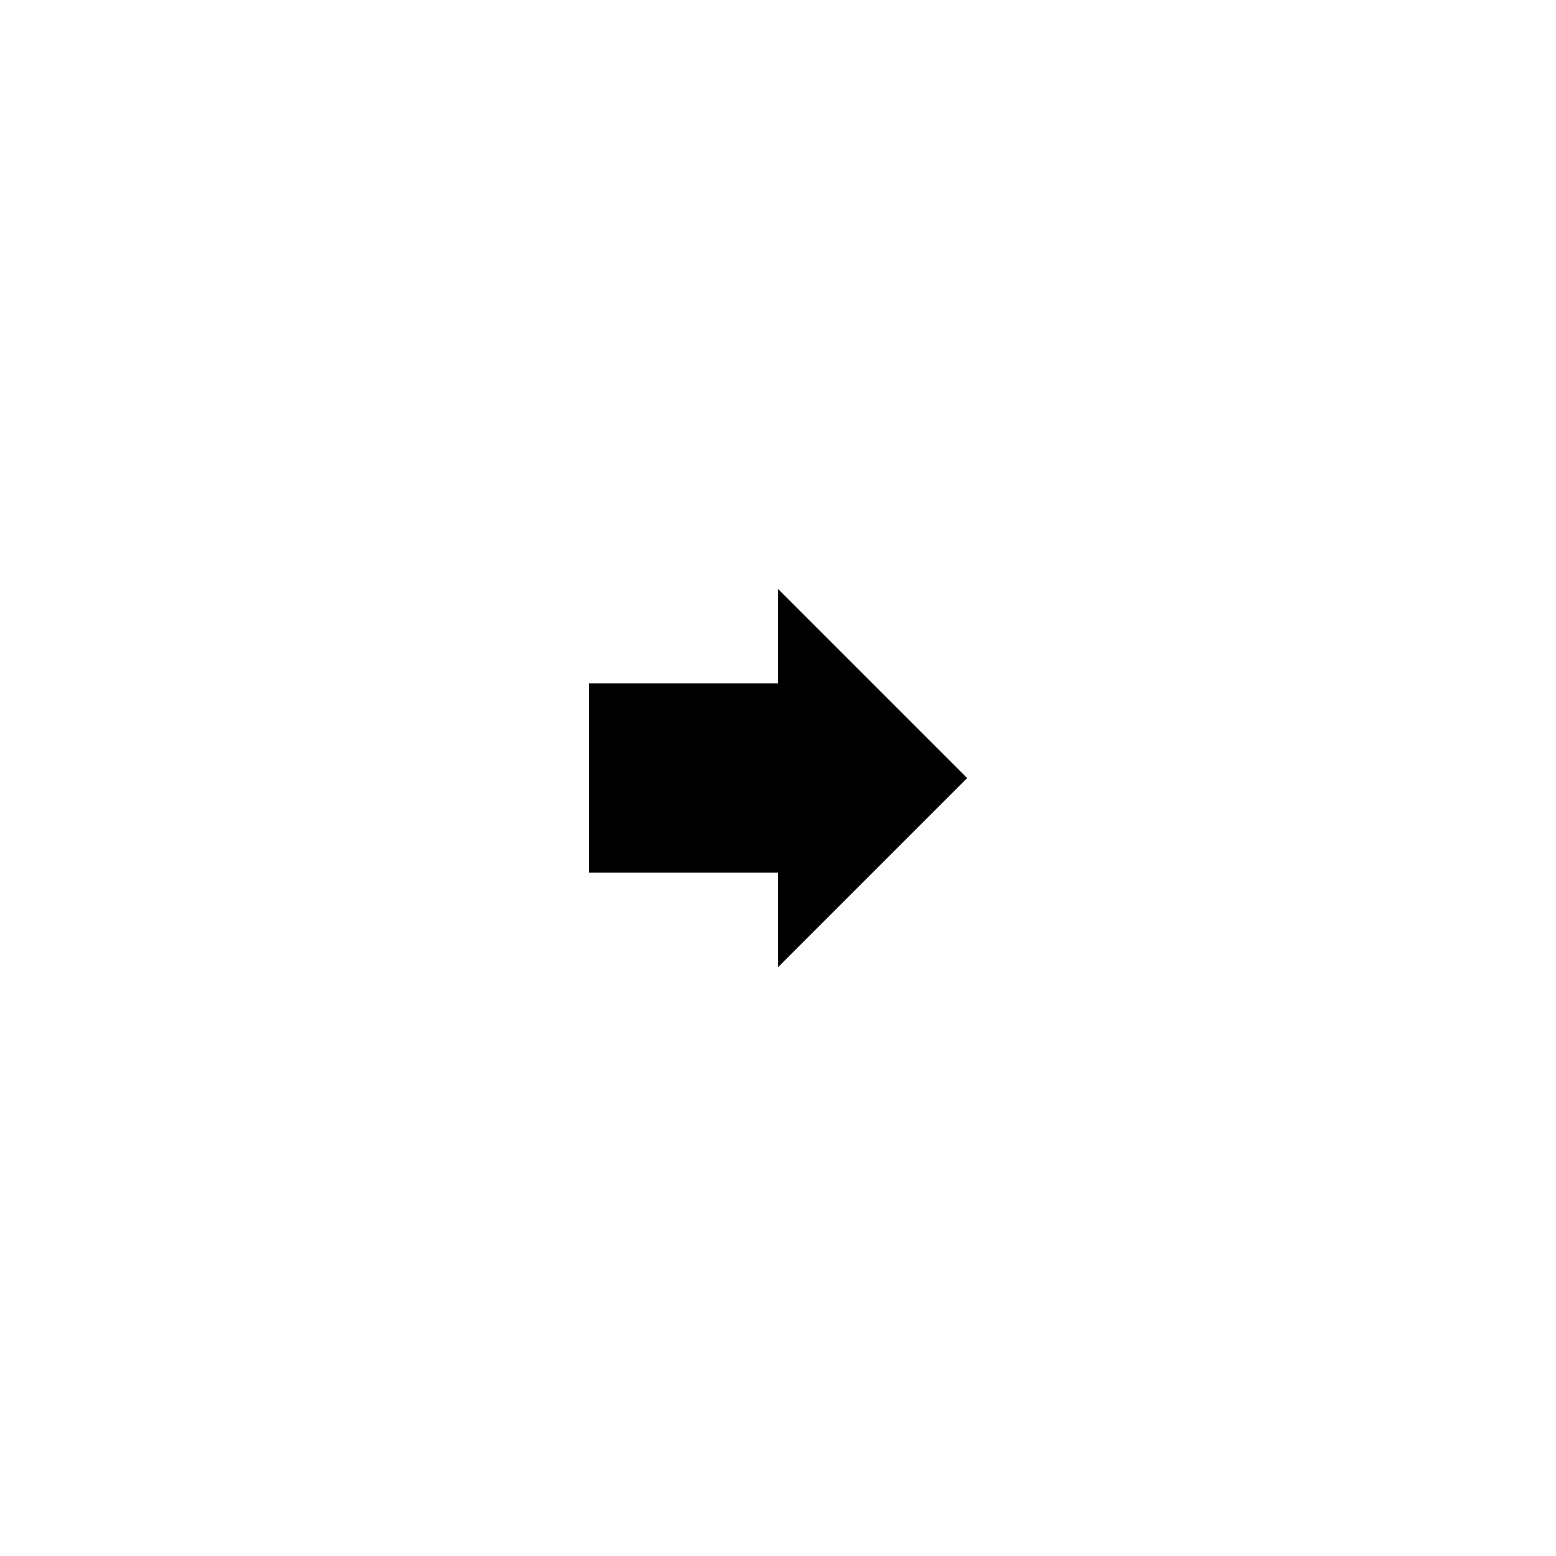

Completed


In [4]:
# @title Grayscale and Threshold { run: "auto", vertical-output: true }

from IPython.display import Image
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

# Define custom weights for RGB to grayscale conversion
def custom_rgb_to_grayscale(image, weights=[0.229, 0.587, 0.114]):
    """
    Convert a 3-channel RGB image to grayscale using custom weights.

    Parameters:
    - image (numpy.ndarray): Input RGB image.
    - weights (list): Custom weights for each RGB channel. Default is [0.229, 0.587, 0.114].

    Returns:
    - numpy.ndarray: Grayscale image.
    """
    # Ensure the image has three color channels (RGB)
    if len(image.shape) == 3 or image.shape[2] == 3\
     or len(image.shape) == 4 or image.shape[2] == 4:
      # Apply custom weights for RGB to grayscale conversion
      gray_image = np.dot(image[..., :3], weights)

    else:
      raise ValueError("Input image must be a 3-channel RGB image.")

    return gray_image

# @markdown $$ \rm{Gray} = Red \times w_1/w + Green\times w_2/w +Blue\times w_3/w $$
# @markdown $$ \rm{w} = w_1 + w_2 + w_3$$

# Custom weights for RGB to grayscale conversion
w1 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
w2 = 1 # @param {type:"slider", min:0, max:1, step:0.01}
w3 = 0 # @param {type:"slider", min:0, max:1, step:0.01}
w = w1 + w2 + w3

# BGR
custom_weights = [w3/w, w2/w, w1/w]

# Display custom weights
print('Custom weights:', custom_weights)

# Current Working Directory
CWD = os.getcwd()

# File paths
file_path_cropped = f"{CWD}/tmp/cropped.png"
file_path_gray = f"{CWD}/tmp/gray.png"
file_path_threshold = f"{CWD}/tmp/threshold.png"

# Display the original color image
print('Original color image')
display(Image(file_path_cropped, width=500))

# Read the resized image
IMG = cv2.imread(file_path_cropped, cv2.IMREAD_UNCHANGED)

# Threshold parameters
threshold = 120 # @param {type:"slider", min:0, max:255, step:1}
inverse = False # @param {type:"boolean"}

# Get image dimensions
height, width = IMG.shape[:2]

# Convert image to grayscale using custom weights
IMG_GRAY = custom_rgb_to_grayscale(IMG, custom_weights)

# Apply thresholding to grayscale image
IMG_GRAY[IMG_GRAY > threshold] = 255.0

# Inverse grayscale image if specified
if inverse:
    IMG_GRAY_INVERSE = 255.0 - IMG_GRAY
    print('Input image successfully inversed')

# Remove existing grayscale and threshold images if they exist
for file_path in [file_path_gray, file_path_threshold]:
    if os.path.exists(file_path):
        os.remove(file_path)

# Save grayscale image
if inverse:
  cv2.imwrite(file_path_gray, IMG_GRAY_INVERSE)
else:
  cv2.imwrite(file_path_gray, IMG_GRAY)

# Display grayscale image
print('Grayscale and Threshold')
display(Image(file_path_gray, width=500))

print('Completed')


###2-3-1. Outline (Option)

As the boundary areas exhibit significant gradients in brightness data, applying a differentiation kernel allows for the extraction of these boundary regions. By setting the extracted boundary parts to 0 and the rest to 1, multiplying this mask with the original image creates a composite image where only the brightness data of the boundary parts is set to 0.

Outline


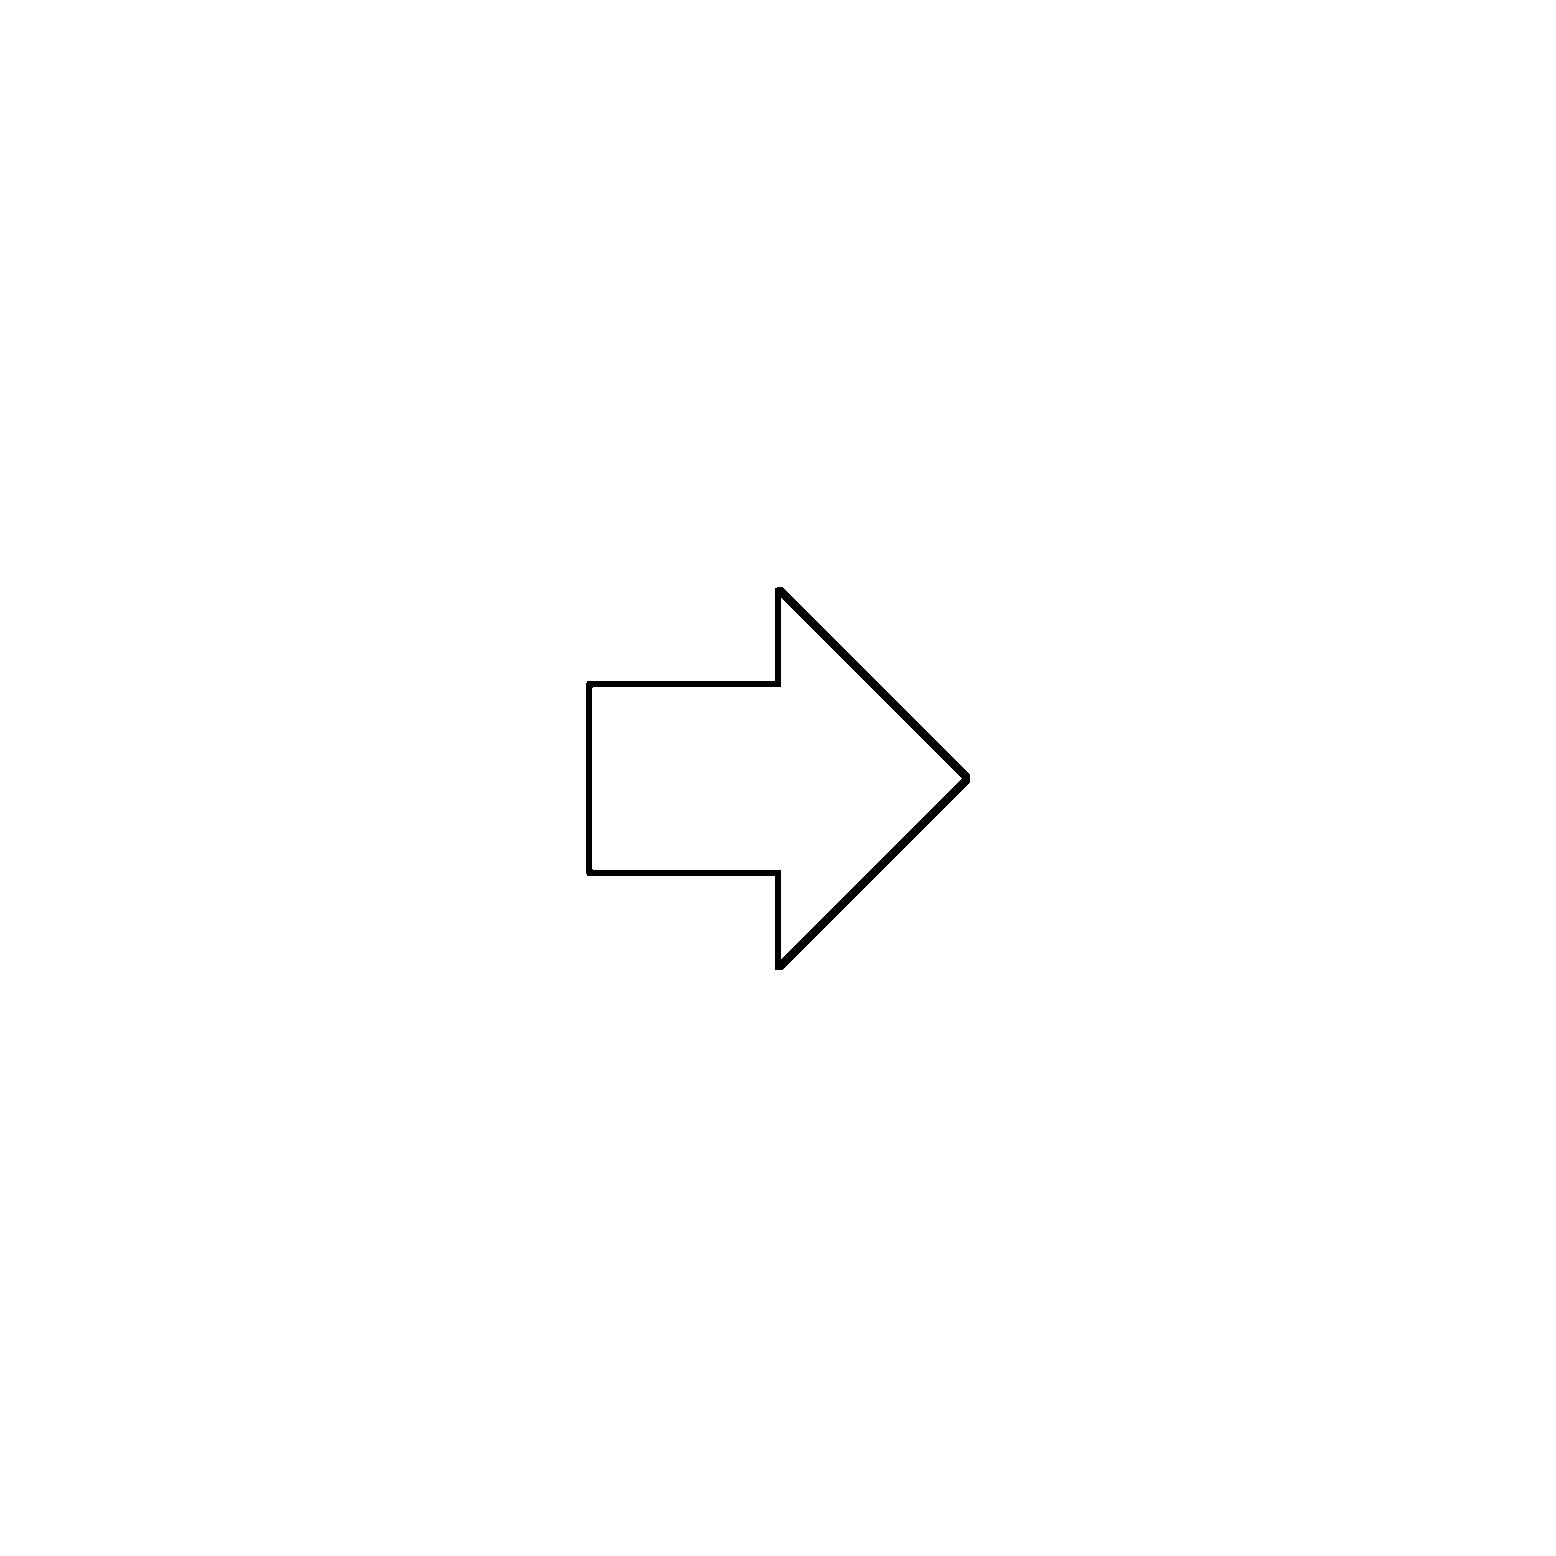

Composite image


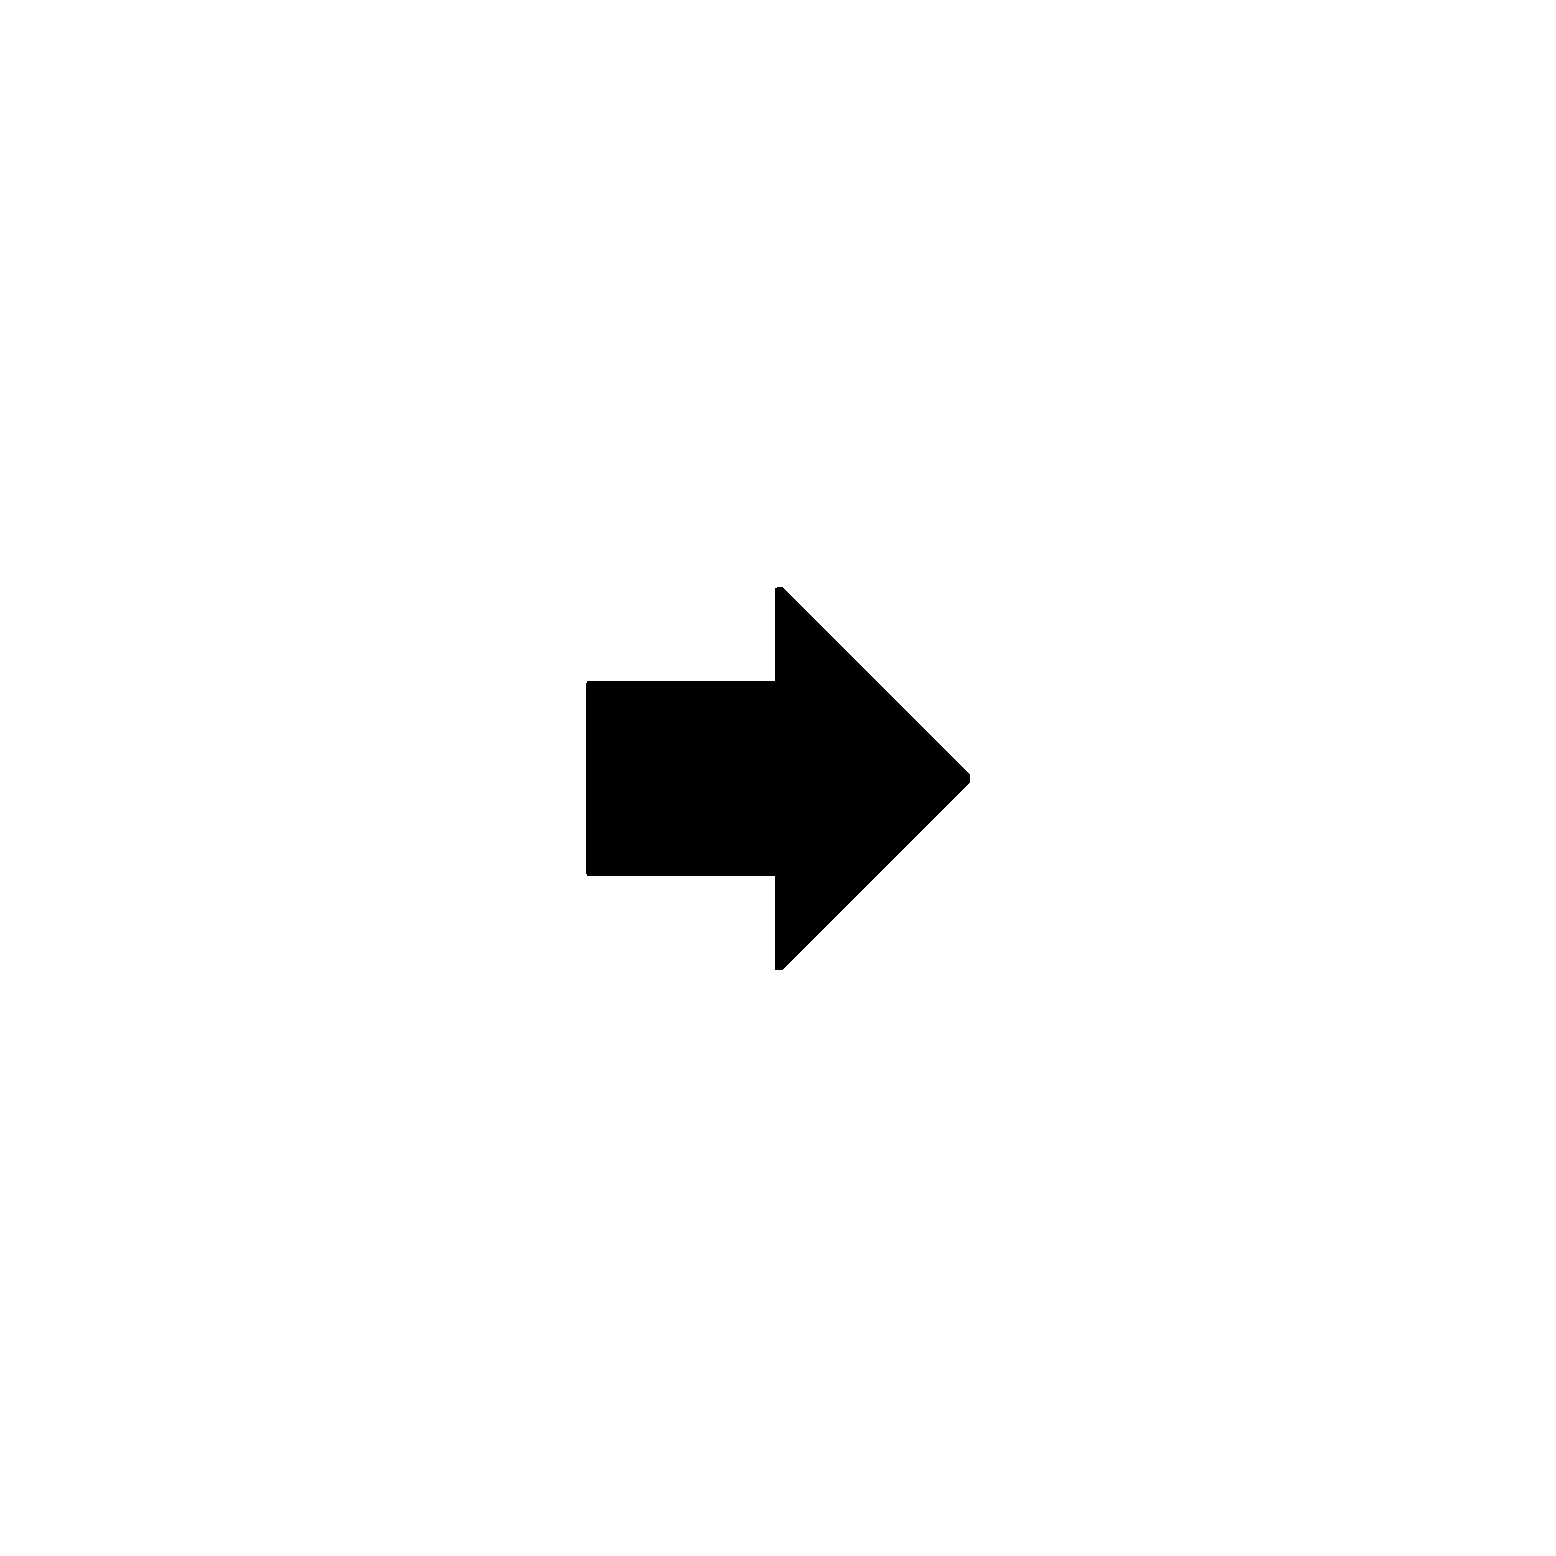

In [ ]:
# @title Option: outline { run: "auto", vertical-output: true }
import cv2
import numpy as np

# Define parameters
kernel_size = 6  # @param {type:"integer"}
threshold1 = 460  # @param {type:"slider", min:0, max:500, step:1}
threshold2 = 202  # @param {type:"slider", min:0, max:500, step:1}

# Current Working Directory
CWD = os.getcwd()

# File paths
file_name_gray = f"{CWD}/tmp/gray.png"
file_name_outline = f"{CWD}/tmp/outline.png"
file_name_com = f"{CWD}/tmp/com.png"

# Read the resized image
IMG = cv2.imread(file_name_gray, cv2.IMREAD_GRAYSCALE)

# Edge detection
edges_inverse = cv2.Canny(IMG, threshold1, threshold2)

# Dilate edges to make them thicker
num_iterations = 1
kernel = np.ones((kernel_size, kernel_size), np.uint8)
edges_dilated = cv2.dilate(edges_inverse, kernel, iterations=num_iterations)

# Invert the edges and save as outline image
edges = 255.0 - edges_dilated
cv2.imwrite(file_name_outline, edges)
print('Outline')
display(Image(file_name_outline, width=500))

# Create a composite image
file_name_com = f"{CWD}/tmp/com.png"
# Normalize (0~1) edges: 0 -> black, 1 -> white
com = edges / 255.0
# Multiply the grayscale image (IMG) by the normalized edges
com = IMG * com
cv2.imwrite(file_name_com, com)
print('Composite image')
display(Image(file_name_com, width=500))


##2-4. Perform resizing and calculate fluid occupancy

1. **Resize**: Adjust the dimensions of the image using appropriate resizing techniques.

2. **Fluid Occupancy**: Determine the fluid occupancy rate by analyzing the resized image. This involves assessing the portion of the image occupied by the fluid, providing valuable insights into the fluid dynamics within the simulated environment.

###2-4-1. Resize
Resizing is done by the function `resize` of the OpenCV module. This function can scale an image by giving a scale factor. For example, a scale factor of 0.5 on a 100x100 image results in a 50x50 image.

Therefore, in order to convert an image to an arbitrary resolution, it is sufficient to know this scale factor. Let $\rm{(W, H)}$ denote the number of pixels in the original image and $\rm{(W', H')}$ the number of pixels in the converted image. Resolution is the total number of pixels, so if the original resolution is $\rm{R}$, the following equation holds.

$$ \rm{R} = WH$$

Here, the number of pixels in the height and width of the converted image $\rm{(W', H')}$ is defined using the scale factor $s( > 0)$ and $\rm{(W, H)}$ as follows.

$$ \rm{(W', H')} = (\textit{s}\rm{W}, \textit{s}\rm{H})$$

This allows the transformed resolution $\rm{R'}$ to be expressed as follows.

$$ \rm{R'} = W'H' = s^2\rm{WH} $$

Solving this for $s$, we obtain.

$$ s = \sqrt{\frac{R'}{WH}} $$

Therefore, given an arbitrary resolution, the coefficient $s$ can be obtained and resizing can be performed. Run the code block below and set the resolution by changing the slider bar of `resolution`. The last value you set will be the resolution used in the following program. The images are stored in the `tmp` folder.

###2-4-2. Fluid Occupancy


Defenition of porosity distribution:

\begin{equation}
\displaystyle \varepsilon = \frac{1}{2} \tanh(x) + \frac{1}{2},\   x = \frac{\xi}{\Delta}
\end{equation}

where $\xi$ is the distance function.

In [ ]:
# @title Max Resolution Check { vertical-output: true }

# Current working directory
CWD = os.getcwd()

file_path_gray = f"{CWD}/tmp/gray.png"

# read an image resized
src = cv2.imread(file_path_gray, cv2.IMREAD_UNCHANGED)
print('Max resolution:', src.shape[0:2])

Max resolution: (1756, 1756)


SPOT DETECTED:  1272
Complete
Boundary area =  215.42
make a porosity distribution
Complete


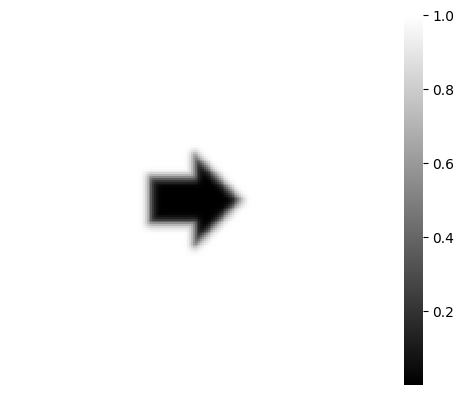

---------------- Processing Results ----------------
Setting resolution  = 40000, (200, 200)
Porosity resolution = 39800, (199, 200)
Threshold     : 120
Minimum value : 1e-06
Shade factor  : 1
Generation Type : SDF
Boundary area = 215.424
-----------------------------------------------------


In [23]:
# @title Occupancy Generation { vertical-output: true }

import seaborn as sns
import numpy as np
import csv
import skfmm
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

resolution = 200  # @param {type: "integer"}
outline = False # @param {type:"boolean"}
generation_type = "SDF" # @param ["SDF", "GaussianBlur"]
thickness = 2.5  # @param {type:"raw"}

CWD = os.getcwd()

def CustomBlurPorosity(img, thickness, blur_type, resolution):
    # Function to apply custom blur and generate porosity
    h, w = img.shape[:2]
    scale_factor = resolution / max(h, w)

    ksize = int(thickness) + (int(thickness) + 1) % 2
    sigma = 0.8576 * thickness / scale_factor

    img_blur_median = cv2.medianBlur(img, ksize=3)

    if blur_type == 'Blur':
        img_blur = cv2.blur(img_blur_median, ksize=(ksize, ksize))
    elif blur_type == 'Gaussian':
        img_blur = cv2.GaussianBlur(img_blur_median, ksize=(ksize, ksize), sigmaX=sigma)

    img_blur_norm = img_blur / 255.0
    porosity = cv2.resize(img_blur_norm, (int(w * scale_factor), int(h * scale_factor)), cv2.INTER_LINEAR)

    return porosity, ksize

def SignedDistanceFieldPorosity(img, thickness, resolution):
    # Function to apply signed distance field method and generate porosity
    h, w = img.shape[:2]
    scale_factor = resolution / max(h, w)
    threshold = 128

    phi = np.where(img < threshold, -1, 1)

    # sns.heatmap(phi)
    # plt.axis('off')
    # file_path_phi = f"{CWD}/tmp/phi.png"
    # plt.savefig(file_path_phi)
    # plt.show()
    # plt.cla()

    sd = skfmm.distance(phi, dx=1)
    # sns.heatmap(sd)
    # plt.axis('off')
    # file_path_sd = f"{CWD}/tmp/sd.png"
    # plt.savefig(file_path_sd)
    # plt.show()
    # plt.cla()

    resized_sd = cv2.resize(sd, (int(w * scale_factor), int(h * scale_factor)), cv2.INTER_LINEAR) * scale_factor
    porosity = np.tanh(resized_sd/thickness) * 0.5 + 0.5

    return porosity

# File paths
if outline:
    file_name_input = f"{CWD}/tmp/com.png"
else:
    file_name_input = f"{CWD}/tmp/gray.png"

file_name_output = f"{CWD}/tmp/porosity_image.png"

# Read the input image
input_image = cv2.imread(file_name_input, cv2.IMREAD_UNCHANGED)

# Resize the image to the specified resolution
h, w = input_image.shape[:2]
scale_factor = resolution / max(h, w)

if generation_type == 'SDF':
    porosity = SignedDistanceFieldPorosity(input_image, thickness, resolution)
elif generation_type == 'GaussianBlur':
    porosity, ksize = CustomBlurPorosity(input_image, thickness, 'Gaussian', resolution)

# Divergence control of porosity distributions
h_resized, w_resized = porosity.shape[:2]
div = 12  # @param {type:"slider", min:0, max:255, step:1}
max_div = div / 255
spot = 0
for i in range(1, h_resized - 1):
    for j in range(1, w_resized - 1):
        n = porosity[i-1][j] - porosity[i][j]
        s = porosity[i+1][j] - porosity[i][j]
        w = porosity[i][j-1] - porosity[i][j]
        e = porosity[i][j+1] - porosity[i][j]
        if abs(n) > max_div or abs(s) > max_div or abs(w) > max_div or abs(e) > max_div:
            spot += 1
            porosity[i][j] = porosity[i-1:i+2,j-1:j+2].mean()

print('SPOT DETECTED: ', spot)
print('Complete')

S = np.sum(porosity - porosity**2)
print("Boundary area = ", format(S, ".2f"))

shade_factor = 1
small = 1.0e-6  # @param {type:"raw"}

#@markdown # Porosity Distribution

print('make a porosity distribution')

# Write porosity distribution
with open('porosity.csv', "w") as file:
    # Write header
    file.write("x,y,porosity\n")

    # Write data
    for j in range(1, h_resized+1):
        for i in range(1, w_resized+1):
            file.write(f"{int(i)}, {int(j)}, {(max(small,porosity[i-1, j-1])):.5f}\n")

with open('process.txt', 'w', encoding='utf-8') as f:
    f.write('---------------- Processing Results ----------------\n')
    f.write(f'Setting resolution  = {porosity.size}, {porosity.shape}\n')
    f.write(f'Porosity resolution = {(porosity.shape[0]-1)*porosity.shape[1]}, {porosity[1:,:].shape}\n')
    f.write(f'Threshold     : {threshold}\n')
    f.write(f'Minimum value : {small}\n')
    f.write(f'Shade factor  : {shade_factor}\n')
    f.write(f'Generation Type : {generation_type}\n')
    if generation_type == 'GaussianBlur':
        f.write(f'Kernel size   : {ksize}\n')
    f.write(f'Boundary area = {S:.3f}\n')
    f.write('-----------------------------------------------------\n')

print('Complete')

# Visualize porosity distribution using heatmap
sns.heatmap(porosity, cmap="gray", xticklabels=False, yticklabels=False, square=True)
plt.savefig(file_name_output)
plt.show()

# Display the content of the process.txt file
%cat process.txt


# 3. CFD

Program [2] for laminar flow calculations of the MAC algorithm using the Immersed boundary method.
### controlDict settings

A controlDict.txt file enables to change some values from it. We need not recompile the program when we change any variables because of using namelist.  
\begin{align}
&CFL = \frac{U\Delta t}{\Delta x} \leq 1 &\\
&Re = \frac{Ul}{\nu} = \frac{\rho Ul}{\mu}\\
&Pe = \frac{U\Delta x}{\nu} < 2\\
&D = \frac{\nu\Delta t}{\Delta x^2} \leq \frac{1}{2}
\end{align}

Where,  
$U$ = Inlet velocity  
$l$ = Representative length in flow direction  
$\nu$ = Kinematic viscosity  
$\mu$ = Dynamic viscosity  
$\rho$ = Density of the fluid

Large Peclet numbers mean that the advection term is dominant, which can lead to unstable calculations. As the program uses central differences, the stability condition for the Peclet number is $Pe < 2$.

## Simulation

The simulation program is written in Python. The `porosity.csv` generated by the above code is read in and the flow field is calculated. The calculation results are output as a file in vtk format and csv format.

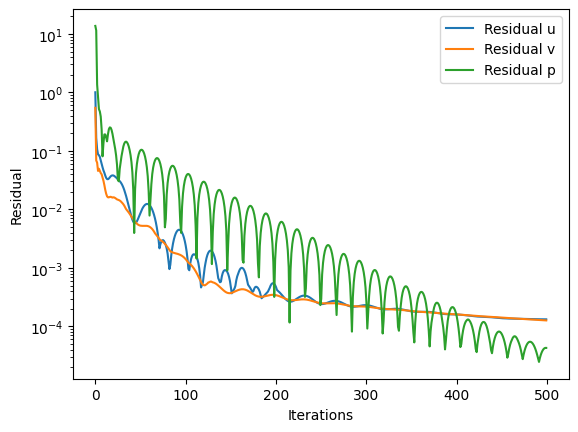

00500 | time = 5.00e+00 | residual_u = 1.32e-04, residual_v = 1.27e-04, residual_p = 4.29e-05
--- PHYSICAL CONDITIONS ---
xnue            = 0.0250
density         = 1.0000
length          = 7.7460
height          = 7.7460
time            = 5.0000
inlet_velocity  = 0.1936
outlet_pressure = 0.0000
AoA             = 0.0000
--- SOLVER IMFORMATION ---
m, n = 200, 200
istep_max = 500
dx, dy = 3.892e-02, 3.892e-02
dt = 1.000e-02
cfl_no = 0.050
pecret_no = 0.302
diffusion_factor = 0.165
reynolds_no = 30
thickness = 2.5
program finished


In [30]:
# @title Simulation program { vertical-output: true }
import os
import time as tm
from tqdm import tqdm
import numpy as np
from numpy import sin, cos, pi, sqrt
from numba import njit, prange
import vtk
import csv

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Read porosity data from CSV file
porosity_file = 'porosity.csv'
porosity_data = np.loadtxt(porosity_file, skiprows=1, delimiter=',')

# Obtain arrays for x, y, and porosity
x_values = porosity_data[:, 0]
y_values = porosity_data[:, 1]
porosity_values = porosity_data[:, 2]

# Obtain the maximum values for x, y
w = int(np.max(x_values))
h = int(np.max(y_values))

resolution = w*h

# Display the extracted values
print(f'Width (w): {w}, Height (h): {h}')

RUN = True # @param {type:"boolean"}

re = 30  # @param {type:"integer"}
dt = 0.01 # @param {type:"raw"}
time = 5 # @param {type:"raw"}

# Safty Factor
safety_factor = 3 # @param {type:"integer"}

output_num = 0 # @param {type:"integer"}

# global constants
small = 1.0e-6
big = 1.0e6
zero = 0.0

# Grid dimentions
m, n = int(w), int(h)

# Ratio of the object to the domain size (for Calcurationg Reynold's Number)
ratio_of_object = 0.5 # @param {type:"raw"}

# Physical parameters
xnue = 0.025000 # (m2/s)
xlamda = 0.000000 # (m2/s)
density = 1.000000 # (kg/m3)

dx = np.sqrt(2*xnue*dt*safety_factor)
length = dx * w
height = dx * h
inlet_velocity = re*xnue/(length*ratio_of_object) #(m/s)
outlet_pressure = 0.000000 # (Pa)
AoA = 0 # @param {type:"integer"}


# Simulation parameters
istep_max       = int(time / dt)
istep_out = int(istep_max/(max(output_num,1)))
if istep_out == istep_max:
  istep_out += 1
thickness       = 2.5

slip = "noslip" # @param ["noslip", "slip"]
if slip == "noslip":
  nonslip = True
else:
  nonslip = False

iter_max = 200 # matrix solver
relux_factor = 1.7

monitor = False # @param {type:"raw"}["True", "False"]
monitor_out = 10 # @param {type:"integer"}

output_folder = 'output'


def main():

    os.makedirs(output_folder, exist_ok=True)

    # Set up physical conditions
    physical_conditions(xnue, density, length, height, time, inlet_velocity, outlet_pressure, AoA)

    # Set up Grid conditions
    dx, dy, dt, porosity, xp, yp, m, n = grid_conditions (xnue, length, height, thickness, time, inlet_velocity, istep_max)

    print(f"istep_max = {istep_max}, istep_out = {istep_out}")

    # Set up initial conditions
    p_init, u_init, v_init = initial_conditions(m, n, inlet_velocity, outlet_pressure, AoA)

    # Set up boundary conditions
    p, u, v = boundary_conditions(p_init, u_init, v_init, xp, yp, length, height, inlet_velocity, outlet_pressure, AoA, porosity)

    if not(RUN):
      return

    print("--- MAC algorithm start ---")
    residuals = {'u': [], 'v': [], 'p': []}

    with tqdm(range(1, istep_max+1)) as t:
        for istep in t:
            mac_time = istep * dt

            p_old = np.copy(p)
            u_old = np.copy(u)
            v_old = np.copy(v)

            # Solve for pressure and update velocity
            p_p, u_p, v_p = solve_p(m, n, p, u, v, u_old, v_old, porosity, xnue, xlamda, density, height, thickness, xp, yp, dx, dy, dt, iter_max, relux_factor, nonslip)
            # Solve for velocity u and v
            u_u = solve_u(m, n, p_p, u_p, v_p, u_old, v_old, porosity, xnue, density, dx, dy, dt)
            v_v = solve_v(m, n, p_p, u_p, v_p, u_old, v_old, porosity, xnue, density, dx, dy, dt)

            # Set up boundary conditions after velocity update
            p, u, v = boundary_conditions(p_p, u_u, v_v, xp, yp, length, height, inlet_velocity, outlet_pressure, AoA, porosity)

            # Monitoring residuals
            residual_p, residual_u, residual_v = calculate_residual(p, u, v, u_old, v_old, p_old)
            residuals['p'].append(residual_p)
            residuals['u'].append(residual_u)
            residuals['v'].append(residual_v)

            # Output results at specified steps
            if istep%istep_out == 0:
                output_paraview(m, n, p, u, v, porosity, xp, yp, f'./{output_folder}/output_{istep:05d}.vts')

            if monitor and istep%monitor_out == 0:
                plot_residuals(residuals, savefig=False)
                description = f"{istep:05} | time = {mac_time:.2e} | residual_p = {residual_p:.2e}"
            else:
                description = f"{istep:05} | time = {mac_time:.2e} | residual_u = {residual_u:.2e}, residual_v = {residual_v:.2e}, residual_p = {residual_p:.2e}"

            t.set_description(description)

    # Final output
    output_paraview(m, n, p, u, v, porosity, xp, yp, f'./{output_folder}/output_final.vts')
    output_solution(m, n, p, u, v, porosity, xp, yp)
    plot_residuals(residuals, savefig=True, filename=f'./{output_folder}/residuals.png')
    description = f"{istep:05} | time = {mac_time:.2e} | residual_u = {residual_u:.2e}, residual_v = {residual_v:.2e}, residual_p = {residual_p:.2e}"
    print(description)

    # Check physical conditions
    physical_conditions(xnue, density, length, height, time, inlet_velocity, outlet_pressure, AoA)
    # Check Grid conditions
    grid_conditions (xnue, length, height, thickness, time, inlet_velocity, istep_max)

    print("program finished")


def calculate_residual(p, u, v, u_old, v_old, p_old):
    residual_p = np.max(np.abs(p - p_old))
    residual_u = np.max(np.abs(u - u_old))
    residual_v = np.max(np.abs(v - v_old))
    return residual_p, residual_u, residual_v


def plot_residuals(residuals, savefig=True, filename="residuals.png"):
    clear_output(wait=True)
    fig, ax = plt.subplots()
    ax.plot(residuals['u'], label='Residual u')
    ax.plot(residuals['v'], label='Residual v')
    ax.plot(residuals['p'], label='Residual p')
    ax.set_yscale('log')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Residual')
    ax.legend()
    if savefig:
        plt.savefig(filename)
    plt.show()


def physical_conditions (xnue, density, length, height, time, inlet_velocity, outlet_pressure, AoA):
    """
    Print and set up physical conditions.

    Parameters:
    - xnue (float): Kinematic viscosity.
    - density (float): Fluid density.
    - length (float): Domain length.
    - height (float): Domain height.
    - time (float): Total simulation time.
    - inlet_velocity (float): Inlet velocity magnitude.
    - outlet_pressure (float): Outlet pressure value.
    - AoA (float): Angle of attack.
    """

    valiables = {"xnue": xnue, "density":density, "length":length, "height":height\
                 , "time":time, "inlet_velocity":inlet_velocity, "outlet_pressure":outlet_pressure, "AoA":AoA}
    blank = 15
    print("--- PHYSICAL CONDITIONS ---")
    for k, v in valiables.items():
        print(f"{k.ljust(blank)} = {v:5.4f}")


def grid_conditions (xnue, length, height, thickness, time, inlet_velocity, istep_max):
    """
    Set up grid conditions.

    Parameters:
    - xnue (float): Kinematic viscosity.
    - length (float): Domain length.
    - height (float): Domain height.
    - thickness (float): Delta/dx.
    - time (float): Total simulation time.
    - inlet_velocity (float): Inlet velocity magnitude.
    - istep_max (int): Maximum number of time steps.

    Returns:
    - dx (float): Grid spacing in the x-direction.
    - dy (float): Grid spacing in the y-direction.
    - dt (float): Time step size.
    - porosity (numpy.ndarray): Porosity field.
    - xp (numpy.ndarray): X-coordinates of grid points.
    - yp (numpy.ndarray): Y-coordinates of grid points.
    """

    # Read porosity data from CSV file
    porosity_file = 'porosity.csv'
    porosity_data = np.loadtxt(porosity_file, skiprows=1, delimiter=',')

    # Obtain arrays for x, y, and porosity
    x_values = porosity_data[:, 0]
    y_values = porosity_data[:, 1]
    porosity_values = porosity_data[:, 2]

    # Obtain the maximum values for x, y
    m = int(np.max(x_values))
    n = int(np.max(y_values))

    porosity = np.ones((m+2, n+2))

    # Extract porosity values
    for x, y, porosity_values in porosity_data:
        porosity[int(x), int(y)] = porosity_values

    porosity = porosity.T

    # Calculate dx, dy, and dt
    dx = length / float(m - 1)
    dy = height / float(n - 1)
    dt = time / float(istep_max)

    # Additional calculations
    radius = ratio_of_object * length
    cfl_no = inlet_velocity * dt / dx
    pecret_no = inlet_velocity * dx / xnue
    diffusion_factor = xnue * dt / dy / dy
    reynolds_no = radius * inlet_velocity / xnue

    xp = np.zeros(m+2)
    yp = np.zeros(n+2)

    for i in range(m+2):
        xp[i] = dx * float(i-1) - length * 0.5

    for i in range(n+2):
        yp[i] = dy * float(i-1) - height * 0.5

    # Print out information
    print("--- SOLVER IMFORMATION ---")
    print(f'm, n = {m}, {n}')
    print(f'istep_max = {istep_max}')
    print(f'dx, dy = {dx:.3e}, {dy:.3e}')
    print(f'dt = {dt:.3e}')
    print(f'cfl_no = {cfl_no:.3f}')
    print(f'pecret_no = {pecret_no:.3f}')
    print(f'diffusion_factor = {diffusion_factor:.3f}')
    print(f'reynolds_no = {reynolds_no:.3g}')
    print(f'thickness = {thickness}')

    return dx, dy, dt, porosity, xp, yp, m, n


def initial_conditions(m, n, inlet_velocity, outlet_pressure, AoA):
    p = np.zeros((m+2, n+2))
    u = np.zeros((m+2, n+2))
    v = np.zeros((m+2, n+2))

    p[:,:] = outlet_pressure
    u[:,:] = inlet_velocity*cos(AoA/180*pi)
    v[:,:] = inlet_velocity*sin(AoA/180*pi)

    return p, u, v


def solve_p(m, n, p, u, v, u_old, v_old, porosity, xnue, xlamda, density, height, thickness, xp, yp, dx, dy, dt, iter_max, relux_factor, nonslip):

    # Initialize
    # ------------ #
    #  Velocity u  #
    # ------------ #
    u_conv_x = np.zeros((m+2, n+2))
    u_conv_y = np.zeros((m+2, n+2))
    u_diff_x = np.zeros((m+2, n+2))
    u_diff_y = np.zeros((m+2, n+2))
    u_div = np.zeros((m+2, n+2))
    u_porosity = np.zeros((m+2, n+2))
    u_wall_force = np.zeros((m+2, n+2))

    u_new = np.copy(u)
    # ------------ #
    #  Velocity v  #
    # ------------ #
    v_conv_x = np.zeros((m+2, n+2))
    v_conv_y = np.zeros((m+2, n+2))
    v_diff_x = np.zeros((m+2, n+2))
    v_diff_y = np.zeros((m+2, n+2))
    v_div = np.zeros((m+2, n+2))
    v_porosity = np.zeros((m+2, n+2))
    v_wall_force = np.zeros((m+2, n+2))
    v_new = np.copy(v)

    # ------------ #
    #  Coefficient #
    # ------------ #
    a_p = np.zeros((m+2, n+2))
    a_e = np.zeros((m+2, n+2))
    a_w = np.zeros((m+2, n+2))
    a_n = np.zeros((m+2, n+2))
    a_s = np.zeros((m+2, n+2))
    b_b = np.zeros((m+2, n+2))

    # ------------ #
    #  Divergence  #
    # ------------ #
    div = np.zeros((m+2, n+2))
    div[1:-1, 1:-1] = (u_old[2:, 1:-1] - u_old[:-2, 1:-1]) / dx * 0.5 \
                    + (v_old[1:-1, 2:] - v_old[1:-1, :-2]) / dy * 0.5

    div[0,:] = 0.0  # inlet
    div[-1:,:] = 0.0 # outlet

    # y-periodic condition
    div[:,0] = div[:,-2]
    div[:,-1] = div[:,1]

    fc = 0.0 # fc = 0 : 2nd central scheme, fc = 1 : 1st upwind scheme

    # for i in range(1, m+1):
    #     for j in range(1, n+1):
    #         # ------------ #
    #         #  Velocity u  #
    #         # ------------ #

    #         # convection x
    #         u_conv_x = - dt * (fc * (np.maximum(u_old[i, j], 0.0) * (u_old[i, j] - u_old[i-1, j]) / dx
    #                                             + min(u_old[i, j], 0.0) * (u_old[i+1, j] - u_old[i, j]) / dx)
    #                                         + (1.0 - fc) * u_old[i, j] * (u_old[i+1, j] - u_old[i-1, j]) / dx * 0.5)
    #         # convection y
    #         u_conv_y = - dt * (fc * (np.maximum(v_old[i, j], 0.0) * (u_old[i, j] - u_old[i, j-1]) / dy
    #                                         + min(v_old[i, j], 0.0) * (u_old[i, j+1] - u_old[i, j]) / dy)
    #                                     + (1.0 - fc) * v_old[i, j] * (u_old[i, j+1] - u_old[i, j-1]) / dy * 0.5)
    #         # diffusion x
    #         u_diff_x = + dt * xnue * (u_old[i+1, j] - 2.0 * u_old[i, j] + u_old[i-1, j]) / dx / dx
    #         # diffusion y
    #         u_diff_y = + dt * xnue * (u_old[i, j+1] - 2.0 * u_old[i, j] + u_old[i, j-1]) / dy / dy
    #         # divergence term
    #         u_div = + dt * (xnue + xlamda) * (div[i+1, j] - div[i-1, j]) / dx * 0.5
    #         # additional terms by porosity profile
    #         u_porosity = + dt * (((u_old[i+1, j] - u_old[i-1, j]) / dx * 0.5 + (u_old[i+1, j] - u_old[i-1, j]) / dx * 0.5)
    #                                     * xnue * (porosity[i+1, j] - porosity[i-1, j]) / dx * 0.5
    #                                     + ((u_old[i, j+1] - u_old[i, j-1]) / dy * 0.5 + (v_old[i+1, j] - v_old[i-1, j]) / dx * 0.5)
    #                                     * xnue * (porosity[i, j+1] - porosity[i, j-1]) / dy * 0.5
    #                                     + div[i, j] * xlamda * (porosity[i+1, j] - porosity[i-1, j]) / dx * 0.5) / porosity[i, j]
    #         # force on wall
    #         if nonslip:
    #             u_wall_force = - dt * xnue * u_old[i, j] / (thickness * dx)**2 * 32.0 * porosity[i, j] * (1.0 - porosity[i, j]) * (1.0 - porosity[i, j])
    #         else:
    #             u_wall_force = 0.0

    #         u_new[i, j] = u_old[i, j] + u_conv_x + u_conv_y + u_diff_x + u_diff_y  + u_div + u_porosity + u_wall_force

    #         # ------------ #
    #         #  Velocity v  #
    #         # ------------ #

    #         # convection_x
    #         v_conv_x = - dt * (fc * (np.maximum(u_old[i, j], 0.0) * (v_old[i, j] - v_old[i-1, j]) / dx
    #                                             + min(u_old[i, j], 0.0) * (v_old[i+1, j] - v_old[i, j]) / dx)
    #                                         + (1.0 - fc) * u_old[i, j] * (v_old[i+1, j] - v_old[i-1, j]) / dx * 0.5)
    #         # convection_y
    #         v_conv_y = - dt * (fc * (np.maximum(v_old[i, j], 0.0) * (v_old[i, j] - v_old[i, j-1]) / dy
    #                                         + min(v_old[i, j], 0.0) * (v_old[i, j+1] - v_old[i, j]) / dy)
    #                                     + (1.0 - fc) * v_old[i, j] * (v_old[i, j+1] - v_old[i, j-1]) / dy * 0.5)
    #         # diffusion_x
    #         v_diff_x = + dt * xnue * (v_old[i+1, j] - 2.0 * v_old[i, j] + v_old[i-1, j]) / dx / dx
    #         # diffusion_y
    #         v_diff_y = + dt * xnue * (v_old[i, j+1] - 2.0 * v_old[i, j] + v_old[i, j-1]) / dy / dy
    #         # divergence term
    #         v_div = + dt * (xnue + xlamda) * (div[i, j+1] - div[i, j-1]) / dy * 0.5
    #         # additional terms by porosity profile
    #         v_porosity = + dt * (((v_old[i+1, j] - v_old[i-1, j]) / dx * 0.5 + (u_old[i, j+1] - u_old[i, j-1]) / dy * 0.5)
    #                                     * xnue * (porosity[i+1, j] - porosity[i-1, j]) / dx * 0.5
    #                                     + ((v_old[i, j+1] - v_old[i, j-1]) / dy * 0.5 + (v_old[i, j+1] - v_old[i, j-1]) / dy * 0.5)
    #                                     * xnue * (porosity[i, j+1] - porosity[i, j-1]) / dy * 0.5
    #                                     + div[i, j] * xlamda * (porosity[i, j+1] - porosity[i, j-1]) / dy * 0.5) / porosity[i, j]
    #         # force on wall
    #         if nonslip:
    #             v_wall_force = - dt * xnue * v_old[i, j] / (thickness * dy)**2 * 32.0 * porosity[i, j] * (1.0 - porosity[i, j]) * (1.0 - porosity[i, j])
    #         else:
    #             v_wall_force = 0

    #         v_new[i, j] = v_old[i, j] + v_conv_x + v_conv_y + v_diff_x + v_diff_y + v_div + v_porosity + v_wall_force

    # Numpy Vector Calcuration
    # ------------ #
    #  Velocity u  #
    # ------------ #
    # convection x
    u_conv_x[1:-1,1:-1] = -dt * (fc * (np.maximum(u_old[1:-1, 1:-1], 0.0) * (u_old[1:-1, 1:-1] - u_old[0:-2, 1:-1]) / dx
                            + np.minimum(u_old[1:-1, 1:-1], 0.0) * (u_old[2:, 1:-1] - u_old[1:-1, 1:-1]) / dx)
                        + (1.0 - fc) * u_old[1:-1, 1:-1] * (u_old[2:, 1:-1] - u_old[0:-2, 1:-1]) / dx * 0.5)
    # convection y
    u_conv_y[1:-1,1:-1] = -dt * (fc * (np.maximum(v_old[1:-1, 1:-1], 0.0) * (u_old[1:-1, 1:-1] - u_old[0:-2, 1:-1]) / dy
                            + np.minimum(v_old[1:-1, 1:-1], 0.0) * (u_old[1:-1, 2:] - u_old[1:-1, 1:-1]) / dy)
                        + (1.0 - fc) * v_old[1:-1, 1:-1] * (u_old[1:-1, 2:] - u_old[1:-1, 0:-2]) / dy * 0.5)
    # diffusion x
    u_diff_x[1:-1,1:-1] = + dt * xnue * (u_old[2:, 1:-1] - 2.0 * u_old[1:-1, 1:-1] + u_old[0:-2, 1:-1]) / dx / dx
    # diffusion y
    u_diff_y[1:-1,1:-1] = + dt * xnue * (u_old[1:-1, 2:] - 2.0 * u_old[1:-1,1:-1] + u_old[1:-1, 0:-2]) / dy / dy
    # divergence term
    u_div[1:-1,1:-1] = + dt * (xnue + xlamda) * (div[2:, 1:-1] - div[0:-2, 1:-1]) / dx * 0.5
    # additional terms by porosity profile
    u_porosity[1:-1,1:-1] = + dt * (((u_old[2:, 1:-1] - u_old[0:-2, 1:-1]) / dx * 0.5 + (u_old[2:, 1:-1] - u_old[0:-2, 1:-1]) / dx * 0.5)
                                * xnue * (porosity[2:, 1:-1] - porosity[0:-2, 1:-1]) / dx * 0.5
                                + ((u_old[1:-1, 2:] - u_old[1:-1, 0:-2]) / dy * 0.5 + (v_old[2:, 1:-1] - v_old[0:-2, 1:-1]) / dx * 0.5)
                                * xnue * (porosity[1:-1, 2:] - porosity[1:-1, 0:-2]) / dy * 0.5
                                + div[1:-1, 1:-1] * xlamda * (porosity[2:, 1:-1] - porosity[0:-2, 1:-1]) / dx * 0.5) / porosity[1:-1,1:-1]
    # force on wall
    if nonslip:
        u_wall_force[1:-1,1:-1] = - dt * xnue * u_old[1:-1,1:-1] / (thickness * dx)**2 * 32.0 * porosity[1:-1,1:-1] * (1.0 - porosity[1:-1,1:-1]) * (1.0 - porosity[1:-1,1:-1])
    else:
        u_wall_force[1:-1,1:-1] = 0.0
    # update u_new
    u_new = u_old + u_conv_x + u_conv_y + u_diff_x + u_diff_y + u_div + u_porosity + u_wall_force
    # ------------ #
    #  Velocity v  #
    # ------------ #
    # convection x
    v_conv_x[1:-1,1:-1] = -dt * (fc * (np.maximum(u_old[1:-1, 1:-1], 0.0) * (v_old[1:-1, 1:-1] - v_old[:-2, 1:-1]) / dx
                                + np.minimum(u_old[1:-1, 1:-1], 0.0) * (v_old[2:, 1:-1] - v_old[1:-1, 1:-1]) / dx)
                            + (1.0 - fc) * u_old[1:-1, 1:-1] * (v_old[2:, 1:-1] - v_old[0:-2, 1:-1]) / dx * 0.5)
    # convection y
    v_conv_y[1:-1,1:-1] = -dt * (fc * (np.maximum(v_old[1:-1, 1:-1], 0.0) * (v_old[1:-1, 1:-1] - v_old[:-2, 1:-1]) / dy
                                + np.minimum(v_old[1:-1, 1:-1], 0.0) * (v_old[1:-1, 2:] - v_old[1:-1, 1:-1]) / dy)
                            + (1.0 - fc) * v_old[1:-1, 1:-1] * (v_old[1:-1, 2:] - v_old[1:-1, 0:-2]) / dy * 0.5)
    # diffusion x
    v_diff_x[1:-1,1:-1] = + dt * xnue * (v_old[2:, 1:-1] - 2.0 * v_old[1:-1, 1:-1] + v_old[0:-2, 1:-1]) / dx / dx
    # diffusion y
    v_diff_y[1:-1,1:-1] = + dt * xnue * (v_old[1:-1, 2:] - 2.0 * v_old[1:-1,1:-1] + v_old[1:-1, 0:-2]) / dy / dy
    # divergence term
    v_div[1:-1,1:-1] = + dt * (xnue + xlamda) * (div[1:-1,2:] - div[1:-1, 0:-2]) / dy * 0.5
    # additional terms by porosity profile
    v_porosity[1:-1,1:-1] = + dt * (((v_old[2:, 1:-1] - v_old[0:-2, 1:-1]) / dx * 0.5 + (v_old[1:-1, 2:] - v_old[1:-1, 0:-2]) / dy * 0.5)
                                * xnue * (porosity[2:, 1:-1] - porosity[0:-2, 1:-1]) / dx * 0.5
                                + ((v_old[1:-1, 2:] - v_old[1:-1, 0:-2]) / dy * 0.5 + (u_old[1:-1, 2:] - u_old[1:-1, 0:-2]) / dy * 0.5)
                                * xnue * (porosity[1:-1, 2:] - porosity[1:-1, 0:-2]) / dy * 0.5
                                + div[1:-1, 1:-1] * xlamda * (porosity[1:-1,2:] - porosity[1:-1,0:-2]) / dy * 0.5) / porosity[1:-1,1:-1]
    # force on wall
    if nonslip:
        v_wall_force[1:-1,1:-1] = - dt * xnue * v_old[1:-1,1:-1] / (thickness * dy)**2 * 32.0 * porosity[1:-1,1:-1] * (1.0 - porosity[1:-1,1:-1]) * (1.0 - porosity[1:-1,1:-1])
    else:
        v_wall_force[1:-1,1:-1] = 0.0
    # update v_new
    v_new = v_old + v_conv_x + v_conv_y + v_diff_x + v_diff_y + v_div + v_porosity + v_wall_force

    # ----------------- #
    #  Matrix Solution  #
    # ----------------- #
    # for i in range(1, m+1):
    #     for j in range(1, n+1):
    #         a_e[i, j] = dt * max(small, (porosity[i+1, j] + porosity[i, j]) * 0.5) / dx / dx
    #         a_w[i, j] = dt * max(small, (porosity[i, j] + porosity[i-1, j]) * 0.5) / dx / dx
    #         a_n[i, j] = dt * max(small, (porosity[i, j+1] + porosity[i, j]) * 0.5) / dy / dy
    #         a_s[i, j] = dt * max(small, (porosity[i, j] + porosity[i, j-1]) * 0.5) / dy / dy
    #         a_p[i, j] = - a_e[i, j] - a_w[i, j] - a_n[i, j] - a_s[i, j]

    #         b_b[i, j] = ((porosity[i+1, j] * u[i, j] + porosity[i, j] * u[i+1, j]) * 0.5 \
    #                     -(porosity[i-1, j] * u[i, j] + porosity[i, j] * u[i-1, j]) * 0.5) * density / dx \
    #                     +((porosity[i, j+1] * v[i, j] + porosity[i, j] * v[i, j+1]) * 0.5 \
    #                     -(porosity[i, j-1] * v[i, j] + porosity[i, j] * v[i, j-1]) * 0.5) * density / dy

    # Numpy Vector Calcuration
    # ----------------- #
    #  Matrix Solution  #
    # ----------------- #
    a_e[1:-1,1:-1] = dt * np.maximum(small, (porosity[2:, 1:-1] + porosity[1:-1, 1:-1]) * 0.5) / dx / dx
    a_w[1:-1,1:-1] = dt * np.maximum(small, (porosity[1:-1, 1:-1] + porosity[0:-2, 1:-1]) * 0.5) / dx / dx
    a_n[1:-1,1:-1] = dt * np.maximum(small, (porosity[1:-1, 2:] + porosity[1:-1, 1:-1]) * 0.5) / dy / dy
    a_s[1:-1,1:-1] = dt * np.maximum(small, (porosity[1:-1, 1:-1] + porosity[1:-1, 0:-2]) * 0.5) / dy / dy
    a_p[1:-1,1:-1] = - a_e[1:-1,1:-1] - a_w[1:-1,1:-1] - a_n[1:-1,1:-1] - a_s[1:-1,1:-1]

    b_b[1:-1,1:-1] = (
        ((porosity[2:, 1:-1] * u[1:-1, 1:-1] + porosity[1:-1, 1:-1] * u[2:, 1:-1]) * 0.5 -
        (porosity[0:-2, 1:-1] * u[1:-1, 1:-1] + porosity[1:-1, 1:-1] * u[0:-2, 1:-1]) * 0.5) * density / dx +
        ((porosity[1:-1, 2:] * v[1:-1, 1:-1] + porosity[1:-1, 1:-1] * v[1:-1, 2:]) * 0.5 -
        (porosity[1:-1, 0:-2] * v[1:-1, 1:-1] + porosity[1:-1, 1:-1] * v[1:-1, 0:-2]) * 0.5) * density / dy
    )

    # -------------------------------------- #
    #  Boundary Conditions for Coefficients  #
    # -------------------------------------- #
    a_pb, a_eb, a_wb, a_nb, a_sb, b_bb = boundary_matrix (p, a_p, a_e, a_w, a_n, a_s, b_b)

    # ---------------------------- #
    #  Matrix Solver (SOR Method)  #
    # ---------------------------- #
    p_new = solve_matrix (m, n, p, a_pb, a_eb, a_wb, a_nb, a_sb, b_bb, iter_max, relux_factor)

    return p_new, u_new, v_new


def solve_u (m, n, p, u, v, u_old, v_old, porosity, xnue, density, dx, dy, dt):
    for i in range(1,m+1):
        for j in range(1,n+1):
            u[i,j] -= dt / density * (p[i+1,j] - p[i-1,j]) / dx * 0.5
    return u


def solve_v (m, n, p, u, v, u_old, v_old, porosity, xnue, density, dx, dy, dt):
    for i in range(1,m+1):
        for j in range(1,n+1):
            v[i,j] -= dt / density * (p[i,j+1] - p[i,j-1]) / dy * 0.5
    return v


@njit
def solve_matrix(m, n, p, a_p, a_e, a_w, a_n, a_s, b_b, iter_max, relux_factor):
    """
    Solves a linear system of equations using the Successive Over-Relaxation (SOR) method.

    Parameters:
    - m, n; Number of Grid points
    - p: 2D array, pressure field to be solved
    - a_p, a_e, a_w, a_n, a_s: Coefficient arrays for the central, east, west, north, and south points
    - b_b: Right-hand side array
    - iter_max: Maximum number of iterations
    - relux_factor (omega): Relaxation factor (1 < omega < 2)

    Returns:
    - p: Updated pressure field
    """

    # p_old = np.copy(p)

    for _ in range(1, iter_max + 1):
        # Default periodic condition in y-direction
        p[:, 0] = p[:, -2]
        p[:, -1] = p[:, 1]

        # p_old = np.copy(p)

        for i in range(1, m+1):
            for j in range(1, n+1):
                p[i, j] = (b_b[i, j] - a_e[i, j] * p[i+1, j] - a_w[i, j] * p[i-1, j]
                           - a_n[i, j] * p[i, j+1] - a_s[i, j] * p[i, j-1]) / a_p[i, j] * relux_factor \
                          + p[i, j] * (1.0 - relux_factor)

    return p


def boundary_matrix (p, a_p, a_e, a_w, a_n, a_s, b_b):
    # inlet (dp/x = 0 at i = 1)
    a_e[1,:] = a_e[1,:] + a_w[1,:]
    a_w[1,:] = 0.0

    # outlet (p = outlet_pressure at i = m)
    b_b[-2,:] = b_b[-2,:] + a_e[-2,:] * p[-1,:]
    a_e[-2,:] = 0.0
    a_w[-2,:] = 0.0
    a_n[-2,:] = 0.0
    a_s[-2,:] = 0.0

    return a_p, a_e, a_w, a_n, a_s, b_b


def boundary_conditions(p, u, v, xp, yp, length, height, inlet_velocity, outlet_pressure, AoA, porosity):
    # ------- #
    #  Inlet  #
    # ------- #
    # u, v = inlet_velocity(cos, sin)
    u[1,:] = inlet_velocity*cos(AoA/180.0*pi)
    v[1,:] = inlet_velocity*sin(AoA/180.0*pi)

    u[0,:] = u[1,:]
    v[0,:] = v[1,:]

    # dp/dx=0 at i=1
    p[0,:] = p[2,:]

    # -------- #
    #  Outlet  #
    # -------- #
    # du/dx=0., dv/dx=0.
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # p=outlet_pressure at i=m
    # p[-2,:] = outlet_pressure
    p[-1,:] = outlet_pressure

    # ------
    # periodic condition (y-direction at j=1 & n)
    # ------
    v[:,0] = v[:,-2]
    u[:,0] = u[:,-2]
    p[:,0] = p[:,-2]
    u[:,-1] = u[:,1]
    v[:,-1] = v[:,1]
    p[:,-1] = p[:,1]

    return p, u, v


def output_paraview(m, n, p, u, v, porosity, xp, yp, filename="output.vts"):
    div = np.zeros((m + 2, n + 2))

    # Create structured grid
    grid = vtk.vtkStructuredGrid()
    grid.SetDimensions(m, n, 1)

    # Create points
    points = vtk.vtkPoints()
    for j in range(1, n+1):
        for i in range(1, m+1):
            points.InsertNextPoint(xp[i], yp[j], 0.0)
    grid.SetPoints(points)

    # Add velocity vector field
    vectors = vtk.vtkDoubleArray()
    vectors.SetName("Velocity")
    vectors.SetNumberOfComponents(3)

    # Add velocityInFluid vector field
    vectors_in_fluid = vtk.vtkDoubleArray()
    vectors_in_fluid.SetName("VelocityInFluid")
    vectors_in_fluid.SetNumberOfComponents(3)

    # Add pressure scalar field
    abs_vectors = vtk.vtkDoubleArray()
    abs_vectors.SetName("AbsoluteVelocity")

    # Add pressure scalar field
    abs_vectors_in_fluid = vtk.vtkDoubleArray()
    abs_vectors_in_fluid.SetName("AbsoluteVelocityInFluid")

    # Add pressure scalar field
    pressure = vtk.vtkDoubleArray()
    pressure.SetName("Pressure")

    # Add VelocityDivergent scalar field
    velocity_divergent = vtk.vtkDoubleArray()
    velocity_divergent.SetName("VelocityDivergent")

    # Add porosity scalar field
    porosity_array = vtk.vtkDoubleArray()
    porosity_array.SetName("Porosity")

    for j in range(1,n+1):
        for i in range(1,m+1):
            vectors.InsertNextTuple3(u[i,j], v[i,j], 0.0)
            vectors_in_fluid.InsertNextTuple3(u[i,j] * porosity[i,j], v[i,j] * porosity[i,j], 0.0)
            abs_vectors.InsertNextValue(sqrt(u[i,j]**2+v[i,j]**2))
            abs_vectors_in_fluid.InsertNextValue(sqrt((u[i,j]*porosity[i,j])**2+(v[i,j]*porosity[i,j])**2))
            pressure.InsertNextValue(p[i,j])
            div[i][j] = (u[i + 1][j] - u[i - 1][j]) / (xp[j + 1] - xp[j - 1]) + (v[i][j + 1] - v[i][j - 1]) / (yp[j + 1] - yp[j - 1])
            velocity_divergent.InsertNextValue(div[i,j])
            porosity_array.InsertNextValue(porosity[i,j])

    grid.GetPointData().AddArray(vectors)
    grid.GetPointData().AddArray(vectors_in_fluid)
    grid.GetPointData().AddArray(abs_vectors)
    grid.GetPointData().AddArray(abs_vectors_in_fluid)
    grid.GetPointData().AddArray(pressure)
    grid.GetPointData().AddArray(velocity_divergent)
    grid.GetPointData().AddArray(porosity_array)

    # Write to VTK file
    writer = vtk.vtkXMLStructuredGridWriter()
    writer.SetFileName(f'{filename}')
    writer.SetInputData(grid)
    writer.Write()


def output_solution(m, n, p, u, v, porosity, xp, yp, filename="output_solution.csv"):
    """
    Output solution values for velocity (u, v) and pressure (p) to a CSV file.

    Parameters:
    - p (numpy.ndarray): Pressure field.
    - u (numpy.ndarray): Velocity component u.
    - v (numpy.ndarray): Velocity component v.
    - porosity (numpy.ndarray): Scalar value of occupancy of fluid.
    - xp (numpy.ndarray): X-coordinates of grid points.
    - yp (numpy.ndarray): Y-coordinates of grid points.
    - filename (str): Output CSV file name. Default is "output_solution.csv".
    """
    with open(filename, "w") as file:
        # Write header
        file.write("x,y,p,u,v,porosity\n")

        # Write data
        for j in range(1, n+1):
            for i in range(1, m+1):
                file.write(f"{xp[i]}, {yp[j]}, {p[i, j]}, {u[i, j]}, {v[i, j]}, {porosity[i, j]}\n")

# Entry point of the script
if __name__ == '__main__':
    main()

# 4. Visualization

Visualizing the output of a numerical simulation.

Grid: (200, 200)
length: 7.75, height: 7.75


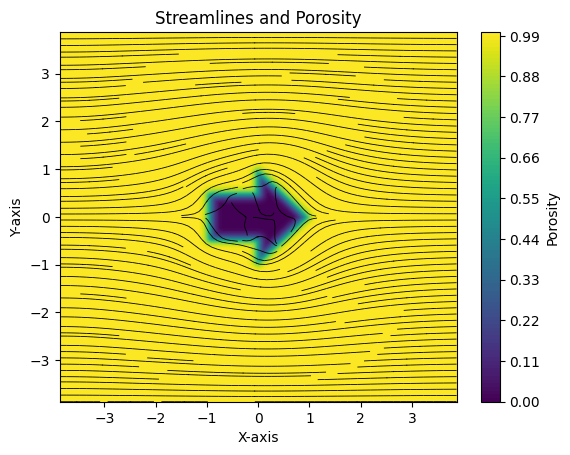

Grid: (200, 200)
length: 7.75, height: 7.75


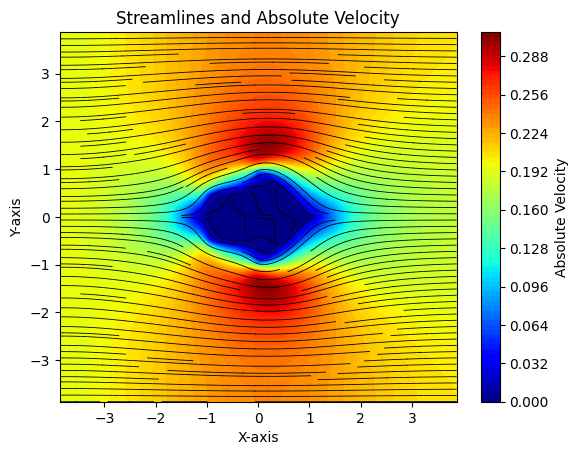

In [28]:
# @title Visualization
def streamlines(filename="output_solution.csv", num=0, streamlines_enable=True, savefig=True, filename_save='streamlines.png'):
    """
    Plot streamlines and contour plots from simulation data.

    Parameters:
    - filename (str): The name of the CSV file containing simulation data.
    - num (int): Indicates which background data to use for contour plots. 0 for porosity, 1 for absolute velocity.
    - streamlines_enable (bool): If True, streamlines will be plotted along with contour plots.
    - savefig (bool): If True, the plot will be saved as an image file.
    - filename_save (str): The filename to use when saving the plot as an image.

    Returns:
    None
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from numpy import sqrt
    import pandas as pd

    # read data
    # filename = "output_solution.csv"
    data = pd.read_csv(filename)

    # Obtain the maximum values for x, y
    m = data['x'].value_counts().values[0]
    n = data['y'].value_counts().values[0]

    print(f'Grid: ({m:0}, {n:0})')

    x_max = np.max(data['x'].values)
    x_min = np.min(data['x'].values)
    y_max = np.max(data['y'].values)
    y_min = np.min(data['y'].values)

    length = x_max - x_min
    height = y_max - y_min

    print(f'length: {length:.2f}, height: {height:.2f}')

    # reshape data
    x = data['x'].values.reshape((m, n))
    y = data['y'].values.reshape((m, n))
    u = data['u'].values.reshape((m, n))
    v = data['v'].values.reshape((m, n))
    p = data['p'].values.reshape((m, n))
    porosity = data['porosity'].values.reshape((m, n))

    u_fluid = u*porosity
    v_fluid = v*porosity
    p_fluid = p*porosity

    abs_velocity = sqrt(u**2+v**2)
    abs_velocity_fluid = sqrt(u_fluid**2+v_fluid**2)

    data = [u,v,p,porosity,u_fluid,v_fluid,p_fluid,\
            abs_velocity,abs_velocity_fluid]

    x = np.linspace(-length/2, length/2, m)
    y = np.linspace(-height/2, height/2, n)
    X, Y = np.meshgrid(x, y)

    # Streamline plot
    # num = 1
    background = ['Porosity', 'Absolute Velocity']
    # streamlines_enable = True

    plt.figure(1)
    title = ''
    # Contour plot
    if num == 0:
        contour = plt.contourf(X, Y, porosity, 100, cmap='viridis', alpha=1.0)
    elif num == 1:
        contour = plt.contourf(X, Y, abs_velocity_fluid, 100, cmap='jet', alpha=1.0)

    if streamlines_enable:
        streamlines = plt.streamplot(X, Y, u_fluid, v_fluid, density=2, color='k', linewidth=0.6, arrowstyle='-', arrowsize=1.0)
        title += f'Streamlines and '

    title += f'{background[num]}'

    cbar = plt.colorbar(contour)
    cbar.set_label(background[num])

    # Title and axis labels
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Display the grid
    plt.grid(False)

    # Save the figure
    if savefig:
        plt.savefig(filename_save)

    # Show the plot
    plt.show()

streamlines(filename="output_solution.csv", num=0, streamlines_enable=True, savefig=True, filename_save='./output/streamlines_porosity.png')
streamlines(filename="output_solution.csv", num=1, streamlines_enable=True, savefig=True, filename_save='./output/streamlines_absVelocity.png')

In [ ]:
# @title Zip output file for download
%mkdir -p download
%cp -r output download
%cp -r tmp download
!zip -r download download

## Reference

[1] Oshima.N, A Novel approach for wall-boundary immersed flow simulation: proposal of modified Navier-Stokes equation, Mechanical Engineering Journal. Vol.18, No.4 (2023)

[2] 大島, 流れの数値解析:固体境界が埋め込まれた改良ナビエ・ストークス方程式の解法, 北海道大学学術成果コレクション(HUBCAP), 資源タイプsoftware (2023), URL: https://eprints.lib.hokudai.ac.jp/dspace/handle/2115/89344